In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import time
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm  # Para la barra de progreso
import os
from PIL import Image
from sklearn.metrics import roc_curve, auc

# Montamos la unidad de drive y trabajamos con los datasets y modelos preparados
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
models_list = []
train_losses_list = []
train_accuracies_list = []
val_losses_list = []
val_accuracies_list = []

In [ ]:
# @title Carga datos
datasetdir = '/content/drive/MyDrive/cbis-ddsm'
X_train_1 = torch.load(datasetdir + "/X_train_balanced.pt")
y_train_1 = torch.load(datasetdir + "/y_train_balanced.pt")
X_test_1 = torch.load(datasetdir + "/X_test.pt")
y_test_1 = torch.load(datasetdir + "/y_test.pt")

X_tensor = torch.load("/content/drive/MyDrive/output/X_oversampled.pt")
y_tensor = torch.load("/content/drive/MyDrive/output/y_oversampled.pt")

from sklearn.model_selection import train_test_split
test_size = 0.2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tensor, y_tensor, test_size=test_size, random_state=42)

X_train_full = torch.cat((X_train_1, X_train_2), dim=0)
y_train_full = torch.cat((y_train_1, y_train_2), dim=0)
X_test_full = torch.cat((X_test_1, X_test_2), dim=0)
y_test_full = torch.cat((y_test_1, y_test_2), dim=0)

# Dataset y DataLoader

X_train = X_train_full
y_train = y_train_full
X_test = X_test_full
y_test = y_test_full

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)  # Conjunto de validación
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

print("Conjunto de entrenamiento:", X_train.shape)
print("Etiquetas de entrenamiento:", y_train.shape)
print("Conjunto de prueba:", X_test.shape)
print("Etiquetas de prueba:", y_test.shape)

Conjunto de entrenamiento: torch.Size([9916, 1, 224, 224])
Etiquetas de entrenamiento: torch.Size([9916])
Conjunto de prueba: torch.Size([2060, 1, 224, 224])
Etiquetas de prueba: torch.Size([2060])


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 14 * 14, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Número total de parámetros entrenables:", total_params)

Número total de parámetros entrenables: 3451777


In [ ]:
# Pruebas de tamaños de tensores para equilibrar las salidas de las redes
cnn = CNN()
entrada = torch.rand(1, 1, 224, 224)
salida = cnn.features(entrada)
salida.shape

torch.Size([1, 128, 14, 14])

In [ ]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()

        # Primera capa
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),  # Normalización por lotes
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)  # Dropout para reducir el sobreajuste
        )

        # Segunda capa
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Tercera capa
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Cuarta capa
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Incrementar profundidad
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        # Clasificador final con Dropout y Batch Normalization
        self.classifier = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = EnhancedCNN()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Número total de parámetros entrenables:", total_params)

Número total de parámetros entrenables: 13234881


In [ ]:
# @title Funciones generales (callbacks, entrenar, métricas)

## Definición de clase para el callback "Early Stopping"
class EarlyStopping:
    def __init__(self, path, patience=3, verbose=False, delta=0.001):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        self.val_loss_min = float('inf')
        self.path = path  # Archivo para guardar el modelo

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping no mejoró en {self.counter} épocas')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if val_loss < self.val_loss_min:
            if self.verbose:
                print(f'Validation loss mejorada a {val_loss:.6f}. Guardando modelo...')
            torch.save(model, self.path)
            self.val_loss_min = val_loss

def trainModel(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, early_stopping):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        start_time = time.time()
        total_loss = 0
        correct_train = 0
        total_train = 0

        model.train()  # Modo de entrenamiento

        # Bucle de entrenamiento
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Precisión del entrenamiento
            predicted = torch.sigmoid(outputs)  # Aplicar sigmoide
            predicted = (predicted > 0.5).float()  # Convertir probabilidades a etiquetas binarias
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validación
        model.eval()  # Modo de evaluación
        val_loss = 0  # Pérdida total de validación
        correct_val = 0  # Número de predicciones correctas
        total_val = 0  # Total de ejemplos evaluados

        with torch.no_grad():  # No calculamos gradientes durante la validación...
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                labels = labels.float().view(-1, 1)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Precisión de validación
                predicted = torch.sigmoid(outputs)
                predicted = (predicted > 0.5).float()
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct_val / total_val

        # Guardar métricas de validación
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        end_time = time.time()
        epoch_duration = end_time - start_time  # Duración de la época

        print(f"Train Loss: {avg_train_loss:.3f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%, Time: {epoch_duration:.2f} seconds")

        # Aplicar Early Stopping y guardar modelo si corresponde
        early_stopping(avg_val_loss, model)  # Usamos pérdida de validación
        if early_stopping.early_stop:
            print("Early Stopping activado. Proceso detenido!")
            break

    return train_losses, train_accuracies, val_losses, val_accuracies

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

def metrics(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    all_preds = []
    all_labels = []

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            outputs = model(images)

        preds = torch.sigmoid(outputs).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds).flatten()
    all_labels = np.array(all_labels).flatten()

    binary_preds = (all_preds > 0.5).astype(int)

    conf_matrix = confusion_matrix(all_labels, binary_preds)

    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negativo', 'Positivo'], yticklabels=['Negativo', 'Positivo'])
    plt.xlabel('Predicciones')
    plt.ylabel('Realidad')
    plt.title('Matriz de Confusión - Existencia de cáncer')
    plt.show()

    accuracy = accuracy_score(all_labels, binary_preds)  # Precisión global
    report = classification_report(all_labels, binary_preds, target_names=['Negativo', 'Positivo'])

    print(f"Precisión global: {accuracy * 100:.2f}%")
    print("\nInforme y métricas de clasificación:")
    print(report)

    precision = precision_score(all_labels, binary_preds)
    recall = recall_score(all_labels, binary_preds)
    f1 = f1_score(all_labels, binary_preds)
    accuracy = accuracy_score(all_labels, binary_preds)

    print(f"Precisión: {precision:.2f}")
    print(f"Sensibilidad (Recall): {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"Accuracy: {accuracy:.2f}")

    true_negatives = conf_matrix[0, 0]
    false_positives = conf_matrix[0, 1]
    true_positives = conf_matrix[1, 1]
    false_negatives = conf_matrix[1, 0]

    specificity = true_negatives / (true_negatives + false_positives)

    print(f"Especificidad: {specificity:.2f}")

    fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    return roc_auc

def graphLossAccuracy(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(7, 3))

    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Val Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Model Loss')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Val Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Model Accuracy')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [ ]:
model = CNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/CombinedCNN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:18<00:00, 34.02it/s]


Train Loss: 0.694, Train Accuracy: 50.84%, Val Loss: 0.6922, Val Accuracy: 53.03%, Time: 19.51 seconds
Validation loss mejorada a 0.692249. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:16<00:00, 37.11it/s]


Train Loss: 0.690, Train Accuracy: 52.56%, Val Loss: 0.6946, Val Accuracy: 52.54%, Time: 17.99 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 619/619 [00:16<00:00, 37.03it/s]


Train Loss: 0.669, Train Accuracy: 57.53%, Val Loss: 0.6837, Val Accuracy: 57.18%, Time: 18.06 seconds
Validation loss mejorada a 0.683744. Guardando modelo...


Epoch 4/30: 100%|██████████| 619/619 [00:16<00:00, 36.84it/s]


Train Loss: 0.598, Train Accuracy: 66.84%, Val Loss: 0.6443, Val Accuracy: 65.19%, Time: 18.11 seconds
Validation loss mejorada a 0.644300. Guardando modelo...


Epoch 5/30: 100%|██████████| 619/619 [00:17<00:00, 36.39it/s]


Train Loss: 0.426, Train Accuracy: 79.88%, Val Loss: 0.5632, Val Accuracy: 75.59%, Time: 18.32 seconds
Validation loss mejorada a 0.563171. Guardando modelo...


Epoch 6/30: 100%|██████████| 619/619 [00:16<00:00, 36.57it/s]


Train Loss: 0.234, Train Accuracy: 90.47%, Val Loss: 0.5927, Val Accuracy: 82.03%, Time: 18.24 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 7/30: 100%|██████████| 619/619 [00:16<00:00, 36.78it/s]


Train Loss: 0.107, Train Accuracy: 96.03%, Val Loss: 0.7436, Val Accuracy: 84.23%, Time: 18.14 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 8/30: 100%|██████████| 619/619 [00:16<00:00, 36.78it/s]


Train Loss: 0.061, Train Accuracy: 97.98%, Val Loss: 0.8594, Val Accuracy: 83.64%, Time: 18.14 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 9/30: 100%|██████████| 619/619 [00:16<00:00, 36.67it/s]


Train Loss: 0.043, Train Accuracy: 98.63%, Val Loss: 1.0221, Val Accuracy: 83.11%, Time: 18.19 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 10/30: 100%|██████████| 619/619 [00:16<00:00, 36.61it/s]


Train Loss: 0.035, Train Accuracy: 99.13%, Val Loss: 1.0545, Val Accuracy: 82.71%, Time: 18.22 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 11/30: 100%|██████████| 619/619 [00:16<00:00, 36.69it/s]


Train Loss: 0.026, Train Accuracy: 99.36%, Val Loss: 1.1780, Val Accuracy: 84.42%, Time: 18.20 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 12/30: 100%|██████████| 619/619 [00:16<00:00, 36.67it/s]


Train Loss: 0.030, Train Accuracy: 99.30%, Val Loss: 1.0764, Val Accuracy: 81.01%, Time: 18.19 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 13/30: 100%|██████████| 619/619 [00:16<00:00, 36.65it/s]


Train Loss: 0.024, Train Accuracy: 99.42%, Val Loss: 1.1061, Val Accuracy: 84.86%, Time: 18.21 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 14/30: 100%|██████████| 619/619 [00:16<00:00, 36.63it/s]


Train Loss: 0.019, Train Accuracy: 99.57%, Val Loss: 1.0687, Val Accuracy: 83.35%, Time: 18.21 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 15/30: 100%|██████████| 619/619 [00:16<00:00, 36.66it/s]


Train Loss: 0.024, Train Accuracy: 99.34%, Val Loss: 1.1341, Val Accuracy: 83.64%, Time: 18.20 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


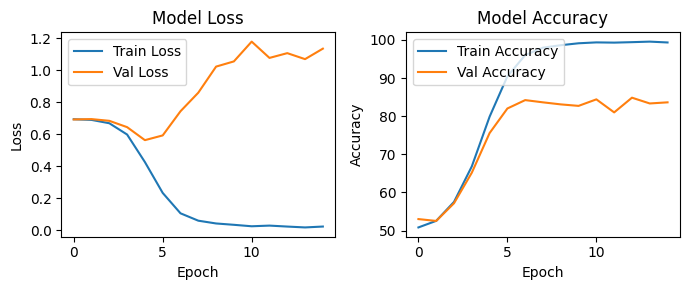

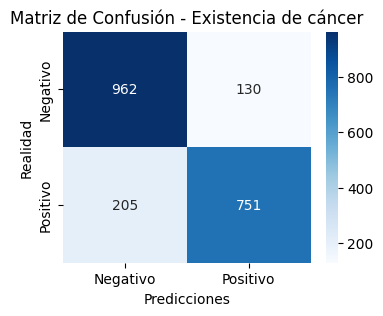

Precisión global: 83.64%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.82      0.88      0.85      1092
    Positivo       0.85      0.79      0.82       956

    accuracy                           0.84      2048
   macro avg       0.84      0.83      0.83      2048
weighted avg       0.84      0.84      0.84      2048

Precisión: 0.85
Sensibilidad (Recall): 0.79
F1-Score: 0.82
Accuracy: 0.84
Especificidad: 0.88


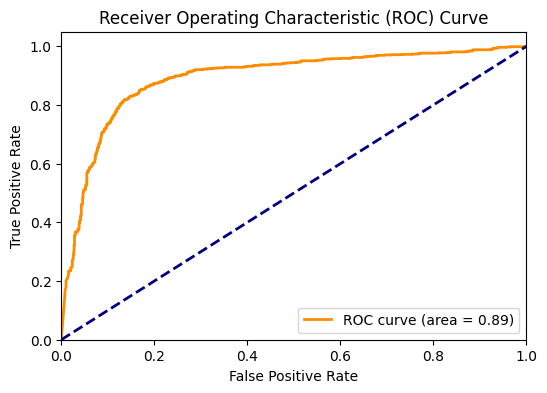

0.8914116740999586

In [ ]:
models_list.append("CNN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_EnhancedCNN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:26<00:00, 23.79it/s]


Train Loss: 0.695, Train Accuracy: 55.48%, Val Loss: 0.6912, Val Accuracy: 54.69%, Time: 27.66 seconds
Validation loss mejorada a 0.691155. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:25<00:00, 24.23it/s]


Train Loss: 0.667, Train Accuracy: 58.91%, Val Loss: 0.6669, Val Accuracy: 60.55%, Time: 27.19 seconds
Validation loss mejorada a 0.666934. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.651, Train Accuracy: 61.00%, Val Loss: 0.6639, Val Accuracy: 60.25%, Time: 27.26 seconds
Validation loss mejorada a 0.663880. Guardando modelo...


Epoch 4/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.629, Train Accuracy: 63.73%, Val Loss: 0.6735, Val Accuracy: 59.13%, Time: 27.22 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 5/30: 100%|██████████| 619/619 [00:25<00:00, 24.21it/s]


Train Loss: 0.605, Train Accuracy: 66.23%, Val Loss: 0.6457, Val Accuracy: 63.77%, Time: 27.20 seconds
Validation loss mejorada a 0.645662. Guardando modelo...


Epoch 6/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.577, Train Accuracy: 69.08%, Val Loss: 0.7032, Val Accuracy: 60.79%, Time: 27.26 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 7/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.545, Train Accuracy: 71.81%, Val Loss: 0.6115, Val Accuracy: 67.97%, Time: 27.24 seconds
Validation loss mejorada a 0.611489. Guardando modelo...


Epoch 8/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.508, Train Accuracy: 74.53%, Val Loss: 0.6282, Val Accuracy: 66.75%, Time: 27.22 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 9/30: 100%|██████████| 619/619 [00:25<00:00, 24.17it/s]


Train Loss: 0.459, Train Accuracy: 78.20%, Val Loss: 0.6102, Val Accuracy: 68.26%, Time: 27.24 seconds
Validation loss mejorada a 0.610159. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [00:25<00:00, 24.21it/s]


Train Loss: 0.425, Train Accuracy: 79.86%, Val Loss: 0.5456, Val Accuracy: 72.66%, Time: 27.21 seconds
Validation loss mejorada a 0.545577. Guardando modelo...


Epoch 11/30: 100%|██████████| 619/619 [00:25<00:00, 24.18it/s]


Train Loss: 0.382, Train Accuracy: 82.96%, Val Loss: 0.5530, Val Accuracy: 73.00%, Time: 27.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 12/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.353, Train Accuracy: 84.55%, Val Loss: 0.5255, Val Accuracy: 75.83%, Time: 27.25 seconds
Validation loss mejorada a 0.525451. Guardando modelo...


Epoch 13/30: 100%|██████████| 619/619 [00:25<00:00, 24.18it/s]


Train Loss: 0.308, Train Accuracy: 87.04%, Val Loss: 0.5350, Val Accuracy: 75.34%, Time: 27.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 14/30: 100%|██████████| 619/619 [00:25<00:00, 24.17it/s]


Train Loss: 0.289, Train Accuracy: 87.83%, Val Loss: 0.5086, Val Accuracy: 77.05%, Time: 27.25 seconds
Validation loss mejorada a 0.508568. Guardando modelo...


Epoch 15/30: 100%|██████████| 619/619 [00:25<00:00, 24.20it/s]


Train Loss: 0.266, Train Accuracy: 88.93%, Val Loss: 0.5429, Val Accuracy: 75.88%, Time: 27.21 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 16/30: 100%|██████████| 619/619 [00:25<00:00, 24.18it/s]


Train Loss: 0.240, Train Accuracy: 90.31%, Val Loss: 0.4930, Val Accuracy: 79.93%, Time: 27.23 seconds
Validation loss mejorada a 0.493031. Guardando modelo...


Epoch 17/30: 100%|██████████| 619/619 [00:25<00:00, 24.18it/s]


Train Loss: 0.222, Train Accuracy: 91.19%, Val Loss: 0.5290, Val Accuracy: 78.66%, Time: 27.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 18/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.205, Train Accuracy: 91.69%, Val Loss: 0.6729, Val Accuracy: 73.88%, Time: 27.25 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 19/30: 100%|██████████| 619/619 [00:25<00:00, 24.18it/s]


Train Loss: 0.188, Train Accuracy: 92.55%, Val Loss: 0.4754, Val Accuracy: 81.45%, Time: 27.23 seconds
Validation loss mejorada a 0.475403. Guardando modelo...


Epoch 20/30: 100%|██████████| 619/619 [00:25<00:00, 24.18it/s]


Train Loss: 0.173, Train Accuracy: 93.27%, Val Loss: 0.6081, Val Accuracy: 75.78%, Time: 27.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 21/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.171, Train Accuracy: 93.10%, Val Loss: 0.4360, Val Accuracy: 84.52%, Time: 27.24 seconds
Validation loss mejorada a 0.436005. Guardando modelo...


Epoch 22/30: 100%|██████████| 619/619 [00:25<00:00, 24.21it/s]


Train Loss: 0.166, Train Accuracy: 93.52%, Val Loss: 0.5693, Val Accuracy: 78.27%, Time: 27.19 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 23/30: 100%|██████████| 619/619 [00:25<00:00, 24.27it/s]


Train Loss: 0.154, Train Accuracy: 93.95%, Val Loss: 0.4968, Val Accuracy: 81.20%, Time: 27.14 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 24/30: 100%|██████████| 619/619 [00:25<00:00, 24.28it/s]


Train Loss: 0.140, Train Accuracy: 94.81%, Val Loss: 0.4345, Val Accuracy: 84.28%, Time: 27.11 seconds
Validation loss mejorada a 0.434478. Guardando modelo...


Epoch 25/30: 100%|██████████| 619/619 [00:25<00:00, 24.25it/s]


Train Loss: 0.131, Train Accuracy: 94.93%, Val Loss: 0.4602, Val Accuracy: 83.74%, Time: 27.15 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 26/30: 100%|██████████| 619/619 [00:25<00:00, 24.28it/s]


Train Loss: 0.133, Train Accuracy: 94.59%, Val Loss: 0.6078, Val Accuracy: 78.56%, Time: 27.12 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 27/30: 100%|██████████| 619/619 [00:25<00:00, 24.30it/s]


Train Loss: 0.134, Train Accuracy: 94.88%, Val Loss: 0.5162, Val Accuracy: 82.13%, Time: 27.11 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 28/30: 100%|██████████| 619/619 [00:25<00:00, 24.31it/s]


Train Loss: 0.116, Train Accuracy: 95.65%, Val Loss: 0.5142, Val Accuracy: 80.52%, Time: 27.09 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 29/30: 100%|██████████| 619/619 [00:25<00:00, 24.30it/s]


Train Loss: 0.110, Train Accuracy: 95.97%, Val Loss: 0.4404, Val Accuracy: 85.50%, Time: 27.10 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 30/30: 100%|██████████| 619/619 [00:25<00:00, 24.30it/s]


Train Loss: 0.115, Train Accuracy: 95.66%, Val Loss: 0.4339, Val Accuracy: 85.89%, Time: 27.10 seconds
EarlyStopping no mejoró en 6 épocas


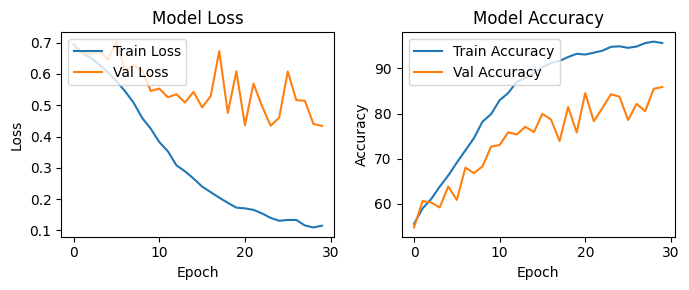

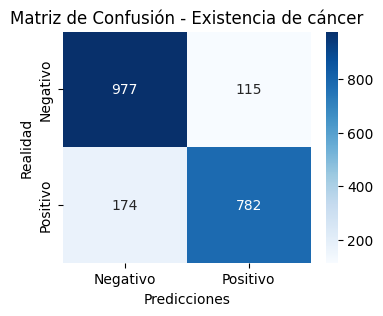

Precisión global: 85.89%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.85      0.89      0.87      1092
    Positivo       0.87      0.82      0.84       956

    accuracy                           0.86      2048
   macro avg       0.86      0.86      0.86      2048
weighted avg       0.86      0.86      0.86      2048

Precisión: 0.87
Sensibilidad (Recall): 0.82
F1-Score: 0.84
Accuracy: 0.86
Especificidad: 0.89


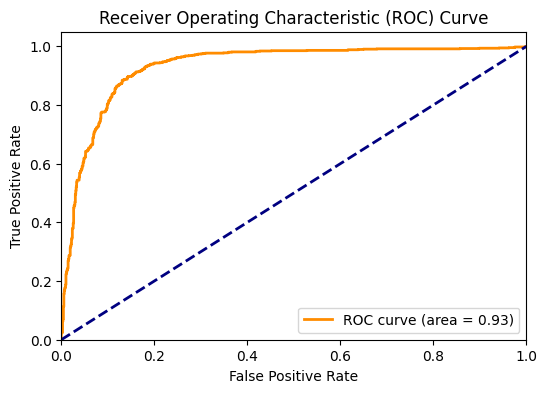

0.931431713335479

In [ ]:
models_list.append("EnhancedCNN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
# Global Contrast Normalization
def global_contrast_normalization(image_tensor, s=1, lmda=10, epsilon=1e-8):
    N, C, H, W = image_tensor.shape
    flat_images = image_tensor.view(N, C, -1)
    mean = flat_images.mean(dim=2, keepdim=True)
    centered_images = flat_images - mean
    contrast = torch.sqrt(lmda + (centered_images ** 2).sum(dim=2, keepdim=True))
    normalized_images = s * centered_images / (contrast + epsilon)
    normalized_images = normalized_images.view(image_tensor.shape)
    return normalized_images

# Aplicar GCN al tensor ya creado
X_tensor_gcn = global_contrast_normalization(X_train)

# Dataset y DataLoader CON GLOBAL CONTRAST NORMALIZATION
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
model = CNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_CNN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:17<00:00, 35.90it/s]


Train Loss: 0.694, Train Accuracy: 50.50%, Val Loss: 0.6935, Val Accuracy: 53.17%, Time: 18.56 seconds
Validation loss mejorada a 0.693519. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:17<00:00, 36.24it/s]


Train Loss: 0.690, Train Accuracy: 53.39%, Val Loss: 0.6901, Val Accuracy: 54.05%, Time: 18.40 seconds
Validation loss mejorada a 0.690135. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [00:17<00:00, 36.41it/s]


Train Loss: 0.668, Train Accuracy: 58.89%, Val Loss: 0.6729, Val Accuracy: 58.25%, Time: 18.34 seconds
Validation loss mejorada a 0.672880. Guardando modelo...


Epoch 4/30: 100%|██████████| 619/619 [00:17<00:00, 36.38it/s]


Train Loss: 0.605, Train Accuracy: 66.67%, Val Loss: 0.6633, Val Accuracy: 63.23%, Time: 18.34 seconds
Validation loss mejorada a 0.663344. Guardando modelo...


Epoch 5/30: 100%|██████████| 619/619 [00:17<00:00, 36.36it/s]


Train Loss: 0.462, Train Accuracy: 77.90%, Val Loss: 0.6045, Val Accuracy: 72.31%, Time: 18.35 seconds
Validation loss mejorada a 0.604471. Guardando modelo...


Epoch 6/30: 100%|██████████| 619/619 [00:17<00:00, 36.09it/s]


Train Loss: 0.300, Train Accuracy: 86.84%, Val Loss: 0.5870, Val Accuracy: 77.78%, Time: 18.47 seconds
Validation loss mejorada a 0.587002. Guardando modelo...


Epoch 7/30: 100%|██████████| 619/619 [00:17<00:00, 36.34it/s]


Train Loss: 0.182, Train Accuracy: 92.47%, Val Loss: 0.5620, Val Accuracy: 81.74%, Time: 18.35 seconds
Validation loss mejorada a 0.561954. Guardando modelo...


Epoch 8/30: 100%|██████████| 619/619 [00:17<00:00, 36.38it/s]


Train Loss: 0.118, Train Accuracy: 95.72%, Val Loss: 0.7321, Val Accuracy: 82.03%, Time: 18.34 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 9/30: 100%|██████████| 619/619 [00:17<00:00, 36.41it/s]


Train Loss: 0.078, Train Accuracy: 97.10%, Val Loss: 0.7320, Val Accuracy: 84.18%, Time: 18.32 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 10/30: 100%|██████████| 619/619 [00:17<00:00, 36.33it/s]


Train Loss: 0.065, Train Accuracy: 97.63%, Val Loss: 0.8990, Val Accuracy: 84.33%, Time: 18.36 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 11/30: 100%|██████████| 619/619 [00:17<00:00, 36.39it/s]


Train Loss: 0.058, Train Accuracy: 97.92%, Val Loss: 0.9471, Val Accuracy: 83.06%, Time: 18.33 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 12/30: 100%|██████████| 619/619 [00:17<00:00, 36.35it/s]


Train Loss: 0.044, Train Accuracy: 98.81%, Val Loss: 0.9019, Val Accuracy: 84.42%, Time: 18.36 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 13/30: 100%|██████████| 619/619 [00:16<00:00, 36.60it/s]


Train Loss: 0.031, Train Accuracy: 99.11%, Val Loss: 1.0916, Val Accuracy: 83.11%, Time: 18.22 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 14/30: 100%|██████████| 619/619 [00:16<00:00, 36.59it/s]


Train Loss: 0.033, Train Accuracy: 99.26%, Val Loss: 0.8353, Val Accuracy: 84.47%, Time: 18.24 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 15/30: 100%|██████████| 619/619 [00:16<00:00, 36.69it/s]


Train Loss: 0.023, Train Accuracy: 99.43%, Val Loss: 0.9964, Val Accuracy: 84.91%, Time: 18.19 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 16/30: 100%|██████████| 619/619 [00:16<00:00, 36.61it/s]


Train Loss: 0.022, Train Accuracy: 99.52%, Val Loss: 0.9600, Val Accuracy: 84.86%, Time: 18.22 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 17/30: 100%|██████████| 619/619 [00:16<00:00, 36.67it/s]


Train Loss: 0.051, Train Accuracy: 98.38%, Val Loss: 0.9750, Val Accuracy: 83.01%, Time: 18.20 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


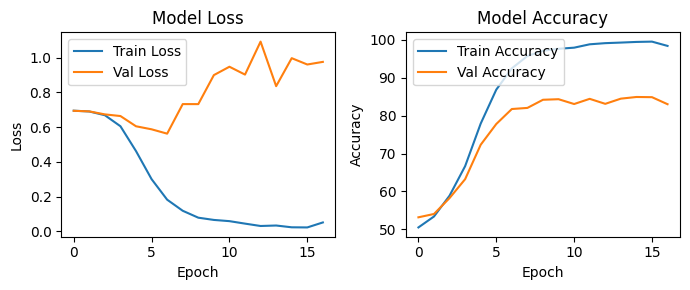

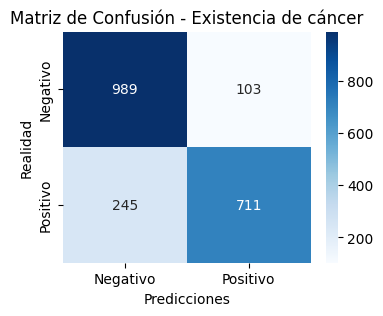

Precisión global: 83.01%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.80      0.91      0.85      1092
    Positivo       0.87      0.74      0.80       956

    accuracy                           0.83      2048
   macro avg       0.84      0.82      0.83      2048
weighted avg       0.84      0.83      0.83      2048

Precisión: 0.87
Sensibilidad (Recall): 0.74
F1-Score: 0.80
Accuracy: 0.83
Especificidad: 0.91


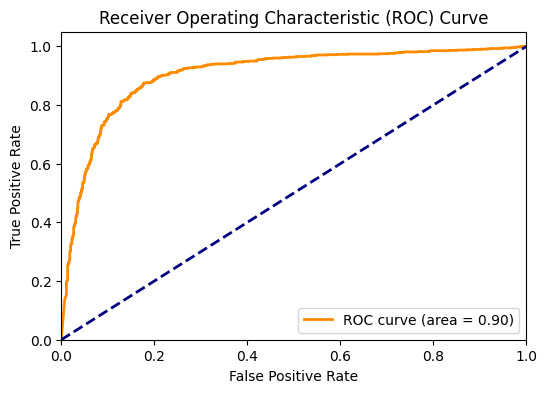

0.9045315301852959

In [ ]:
models_list.append("CNN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_EnhancedCNN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:26<00:00, 23.80it/s]


Train Loss: 0.701, Train Accuracy: 53.85%, Val Loss: 0.6859, Val Accuracy: 57.57%, Time: 27.64 seconds
Validation loss mejorada a 0.685851. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:25<00:00, 24.31it/s]


Train Loss: 0.668, Train Accuracy: 58.94%, Val Loss: 0.7132, Val Accuracy: 55.13%, Time: 27.09 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 619/619 [00:25<00:00, 24.29it/s]


Train Loss: 0.654, Train Accuracy: 61.74%, Val Loss: 0.6611, Val Accuracy: 59.77%, Time: 27.11 seconds
Validation loss mejorada a 0.661105. Guardando modelo...


Epoch 4/30: 100%|██████████| 619/619 [00:25<00:00, 24.24it/s]


Train Loss: 0.638, Train Accuracy: 63.49%, Val Loss: 0.6858, Val Accuracy: 59.67%, Time: 27.17 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 5/30: 100%|██████████| 619/619 [00:25<00:00, 24.31it/s]


Train Loss: 0.612, Train Accuracy: 65.86%, Val Loss: 0.6406, Val Accuracy: 62.30%, Time: 27.09 seconds
Validation loss mejorada a 0.640603. Guardando modelo...


Epoch 6/30: 100%|██████████| 619/619 [00:25<00:00, 24.34it/s]


Train Loss: 0.584, Train Accuracy: 68.79%, Val Loss: 0.6211, Val Accuracy: 66.41%, Time: 27.06 seconds
Validation loss mejorada a 0.621134. Guardando modelo...


Epoch 7/30: 100%|██████████| 619/619 [00:25<00:00, 24.29it/s]


Train Loss: 0.555, Train Accuracy: 71.29%, Val Loss: 0.6049, Val Accuracy: 67.38%, Time: 27.10 seconds
Validation loss mejorada a 0.604864. Guardando modelo...


Epoch 8/30: 100%|██████████| 619/619 [00:25<00:00, 24.27it/s]


Train Loss: 0.514, Train Accuracy: 74.39%, Val Loss: 0.6630, Val Accuracy: 66.16%, Time: 27.14 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 9/30: 100%|██████████| 619/619 [00:25<00:00, 24.14it/s]


Train Loss: 0.481, Train Accuracy: 76.47%, Val Loss: 0.5468, Val Accuracy: 74.51%, Time: 27.27 seconds
Validation loss mejorada a 0.546788. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [00:25<00:00, 24.05it/s]


Train Loss: 0.440, Train Accuracy: 79.55%, Val Loss: 0.5388, Val Accuracy: 74.46%, Time: 27.39 seconds
Validation loss mejorada a 0.538827. Guardando modelo...


Epoch 11/30: 100%|██████████| 619/619 [00:25<00:00, 24.13it/s]


Train Loss: 0.390, Train Accuracy: 82.45%, Val Loss: 0.5855, Val Accuracy: 71.29%, Time: 27.28 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 12/30: 100%|██████████| 619/619 [00:25<00:00, 24.15it/s]


Train Loss: 0.348, Train Accuracy: 84.80%, Val Loss: 0.5313, Val Accuracy: 75.78%, Time: 27.28 seconds
Validation loss mejorada a 0.531300. Guardando modelo...


Epoch 13/30: 100%|██████████| 619/619 [00:25<00:00, 24.17it/s]


Train Loss: 0.320, Train Accuracy: 86.24%, Val Loss: 0.4771, Val Accuracy: 79.00%, Time: 27.25 seconds
Validation loss mejorada a 0.477129. Guardando modelo...


Epoch 14/30: 100%|██████████| 619/619 [00:25<00:00, 24.21it/s]


Train Loss: 0.291, Train Accuracy: 87.52%, Val Loss: 0.4460, Val Accuracy: 82.42%, Time: 27.20 seconds
Validation loss mejorada a 0.446018. Guardando modelo...


Epoch 15/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.259, Train Accuracy: 89.29%, Val Loss: 0.4908, Val Accuracy: 80.03%, Time: 27.22 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 16/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.239, Train Accuracy: 90.06%, Val Loss: 0.4301, Val Accuracy: 82.13%, Time: 27.22 seconds
Validation loss mejorada a 0.430052. Guardando modelo...


Epoch 17/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.229, Train Accuracy: 90.54%, Val Loss: 0.4406, Val Accuracy: 81.45%, Time: 27.22 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 18/30: 100%|██████████| 619/619 [00:25<00:00, 24.20it/s]


Train Loss: 0.210, Train Accuracy: 91.44%, Val Loss: 0.4509, Val Accuracy: 82.23%, Time: 27.21 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 19/30: 100%|██████████| 619/619 [00:25<00:00, 24.20it/s]


Train Loss: 0.195, Train Accuracy: 92.07%, Val Loss: 0.4668, Val Accuracy: 82.47%, Time: 27.22 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 20/30: 100%|██████████| 619/619 [00:25<00:00, 24.25it/s]


Train Loss: 0.181, Train Accuracy: 92.89%, Val Loss: 0.4023, Val Accuracy: 84.72%, Time: 27.16 seconds
Validation loss mejorada a 0.402252. Guardando modelo...


Epoch 21/30: 100%|██████████| 619/619 [00:25<00:00, 24.20it/s]


Train Loss: 0.173, Train Accuracy: 92.98%, Val Loss: 0.4895, Val Accuracy: 81.59%, Time: 27.23 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 22/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.164, Train Accuracy: 93.24%, Val Loss: 0.4662, Val Accuracy: 82.67%, Time: 27.21 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 23/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.172, Train Accuracy: 93.30%, Val Loss: 0.5415, Val Accuracy: 79.54%, Time: 27.22 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 24/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.144, Train Accuracy: 94.51%, Val Loss: 0.4288, Val Accuracy: 85.16%, Time: 27.22 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 25/30: 100%|██████████| 619/619 [00:25<00:00, 24.20it/s]


Train Loss: 0.134, Train Accuracy: 95.09%, Val Loss: 0.4527, Val Accuracy: 83.59%, Time: 27.22 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 26/30: 100%|██████████| 619/619 [00:25<00:00, 24.21it/s]


Train Loss: 0.133, Train Accuracy: 94.81%, Val Loss: 0.5253, Val Accuracy: 81.93%, Time: 27.21 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 27/30: 100%|██████████| 619/619 [00:25<00:00, 24.17it/s]


Train Loss: 0.127, Train Accuracy: 95.30%, Val Loss: 0.4327, Val Accuracy: 84.18%, Time: 27.25 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 28/30: 100%|██████████| 619/619 [00:25<00:00, 24.07it/s]


Train Loss: 0.123, Train Accuracy: 95.35%, Val Loss: 0.4441, Val Accuracy: 85.06%, Time: 27.34 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 29/30: 100%|██████████| 619/619 [00:25<00:00, 24.15it/s]


Train Loss: 0.121, Train Accuracy: 95.67%, Val Loss: 0.4825, Val Accuracy: 82.18%, Time: 27.25 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 30/30: 100%|██████████| 619/619 [00:25<00:00, 24.22it/s]


Train Loss: 0.110, Train Accuracy: 95.99%, Val Loss: 0.4871, Val Accuracy: 84.28%, Time: 27.20 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


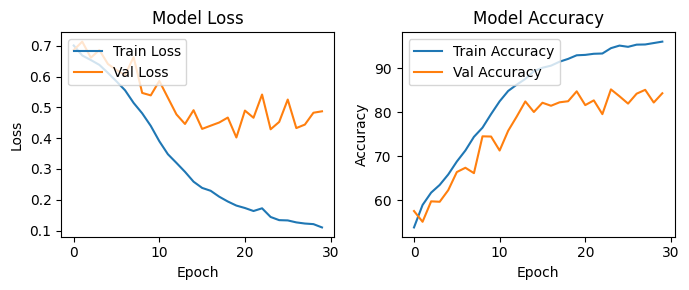

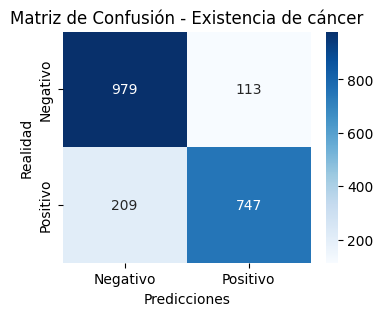

Precisión global: 84.28%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.82      0.90      0.86      1092
    Positivo       0.87      0.78      0.82       956

    accuracy                           0.84      2048
   macro avg       0.85      0.84      0.84      2048
weighted avg       0.84      0.84      0.84      2048

Precisión: 0.87
Sensibilidad (Recall): 0.78
F1-Score: 0.82
Accuracy: 0.84
Especificidad: 0.90


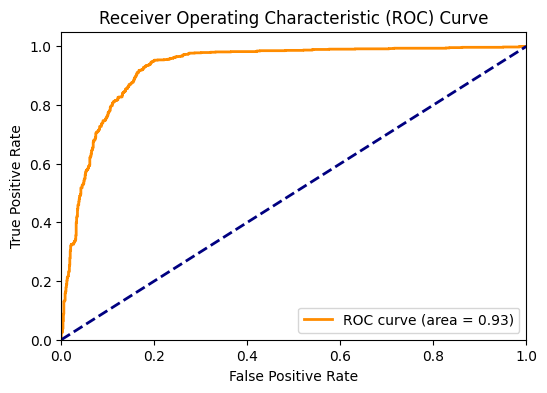

0.926904685272886

In [ ]:
models_list.append("EnhancedCNN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
from skimage import exposure

def local_contrast_normalization(tensor, kernel_size=7):
    image = tensor.cpu().numpy()
    images = []

    for i in range(image.shape[0]):
        img = image[i]
        local_mean = F.avg_pool2d(torch.tensor(img).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze().numpy()
        local_sqr_mean = F.avg_pool2d(torch.tensor(img**2).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze().numpy()
        local_var = local_sqr_mean - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 1e-10))
        lcn_image = (img - local_mean) / (local_std + 1e-10)

        images.append(lcn_image)

    tensor = torch.tensor(np.stack(images)).to(tensor.device)
    return tensor

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)

    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev ** 2 + 1e-6)

    return gcn_image_tensor

def LCN_GCN_preprocess(tensor):
    gcn_tensor = global_contrast_normalization(tensor)
    lcn_tensor = local_contrast_normalization(gcn_tensor)

    return lcn_tensor

X_train_LCN_GCN = LCN_GCN_preprocess(X_train)
X_test_LCN_GCN = LCN_GCN_preprocess(X_test)
# X_tensor_gcn = global_contrast_normalization(X_tensor)

# Dataset y DataLoader CON LOCAL CONTRAST NORMALIZATION Y GLOBAL CONTRAST NORMALIZATION
train_dataset = TensorDataset(X_train_LCN_GCN, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test_LCN_GCN, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
model = CNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_CNN_LCN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:18<00:00, 34.21it/s]


Train Loss: 0.687, Train Accuracy: 53.91%, Val Loss: 0.6965, Val Accuracy: 52.88%, Time: 19.41 seconds
Validation loss mejorada a 0.696457. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:16<00:00, 37.05it/s]


Train Loss: 0.645, Train Accuracy: 60.60%, Val Loss: 0.6957, Val Accuracy: 57.52%, Time: 18.04 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 619/619 [00:16<00:00, 36.92it/s]


Train Loss: 0.576, Train Accuracy: 67.66%, Val Loss: 0.7179, Val Accuracy: 60.11%, Time: 18.08 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 4/30: 100%|██████████| 619/619 [00:16<00:00, 36.72it/s]


Train Loss: 0.463, Train Accuracy: 77.87%, Val Loss: 0.7624, Val Accuracy: 66.55%, Time: 18.18 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 5/30: 100%|██████████| 619/619 [00:17<00:00, 36.39it/s]


Train Loss: 0.293, Train Accuracy: 87.25%, Val Loss: 1.0541, Val Accuracy: 73.78%, Time: 18.33 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 6/30: 100%|██████████| 619/619 [00:17<00:00, 36.34it/s]


Train Loss: 0.168, Train Accuracy: 93.84%, Val Loss: 0.9875, Val Accuracy: 79.93%, Time: 18.36 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 7/30: 100%|██████████| 619/619 [00:17<00:00, 36.22it/s]


Train Loss: 0.091, Train Accuracy: 97.18%, Val Loss: 1.2559, Val Accuracy: 79.69%, Time: 18.40 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 8/30: 100%|██████████| 619/619 [00:17<00:00, 36.17it/s]


Train Loss: 0.056, Train Accuracy: 98.30%, Val Loss: 1.6001, Val Accuracy: 80.57%, Time: 18.44 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 9/30: 100%|██████████| 619/619 [00:17<00:00, 36.39it/s]


Train Loss: 0.045, Train Accuracy: 98.67%, Val Loss: 1.5342, Val Accuracy: 83.11%, Time: 18.32 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 10/30: 100%|██████████| 619/619 [00:16<00:00, 36.42it/s]


Train Loss: 0.029, Train Accuracy: 99.18%, Val Loss: 1.8461, Val Accuracy: 80.96%, Time: 18.33 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 11/30: 100%|██████████| 619/619 [00:16<00:00, 36.44it/s]


Train Loss: 0.046, Train Accuracy: 98.83%, Val Loss: 1.9729, Val Accuracy: 80.03%, Time: 18.30 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


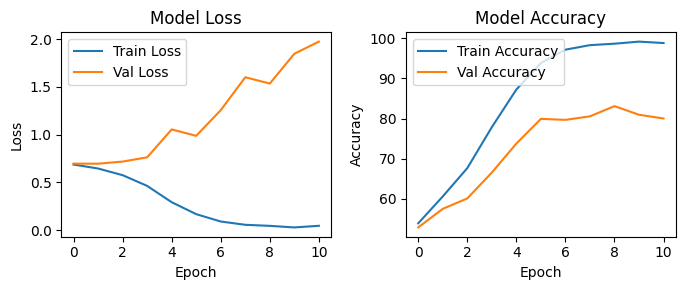

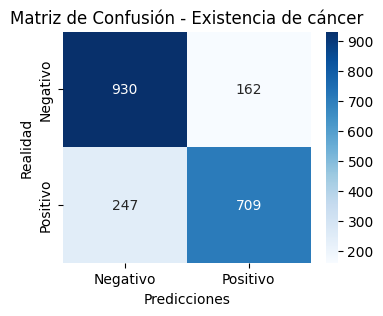

Precisión global: 80.03%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.79      0.85      0.82      1092
    Positivo       0.81      0.74      0.78       956

    accuracy                           0.80      2048
   macro avg       0.80      0.80      0.80      2048
weighted avg       0.80      0.80      0.80      2048

Precisión: 0.81
Sensibilidad (Recall): 0.74
F1-Score: 0.78
Accuracy: 0.80
Especificidad: 0.85


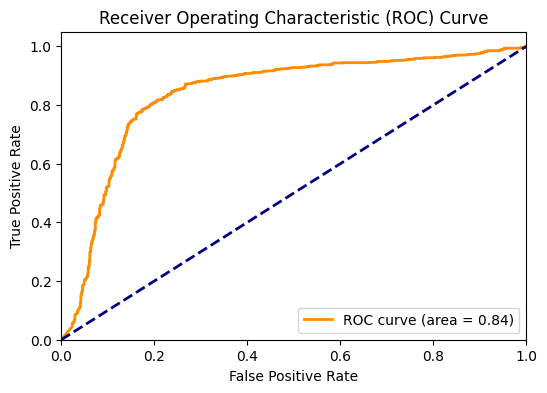

0.8387986229251919

In [ ]:
models_list.append("CNN-LCN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_CNN_LCN_GCN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:25<00:00, 24.12it/s]


Train Loss: 0.685, Train Accuracy: 57.33%, Val Loss: 0.6909, Val Accuracy: 56.20%, Time: 27.30 seconds
Validation loss mejorada a 0.690935. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:25<00:00, 23.96it/s]


Train Loss: 0.648, Train Accuracy: 61.15%, Val Loss: 0.6803, Val Accuracy: 55.86%, Time: 27.47 seconds
Validation loss mejorada a 0.680341. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [00:25<00:00, 24.15it/s]


Train Loss: 0.632, Train Accuracy: 63.18%, Val Loss: 0.7042, Val Accuracy: 57.18%, Time: 27.26 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 4/30: 100%|██████████| 619/619 [00:25<00:00, 24.15it/s]


Train Loss: 0.612, Train Accuracy: 65.28%, Val Loss: 0.6738, Val Accuracy: 60.55%, Time: 27.26 seconds
Validation loss mejorada a 0.673828. Guardando modelo...


Epoch 5/30: 100%|██████████| 619/619 [00:25<00:00, 24.02it/s]


Train Loss: 0.592, Train Accuracy: 67.18%, Val Loss: 0.7783, Val Accuracy: 53.47%, Time: 27.40 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 6/30: 100%|██████████| 619/619 [00:25<00:00, 24.06it/s]


Train Loss: 0.564, Train Accuracy: 69.82%, Val Loss: 0.6728, Val Accuracy: 64.40%, Time: 27.37 seconds
Validation loss mejorada a 0.672761. Guardando modelo...


Epoch 7/30: 100%|██████████| 619/619 [00:25<00:00, 24.13it/s]


Train Loss: 0.534, Train Accuracy: 71.98%, Val Loss: 0.6411, Val Accuracy: 66.55%, Time: 27.29 seconds
Validation loss mejorada a 0.641104. Guardando modelo...


Epoch 8/30: 100%|██████████| 619/619 [00:25<00:00, 24.13it/s]


Train Loss: 0.499, Train Accuracy: 75.18%, Val Loss: 0.6260, Val Accuracy: 65.92%, Time: 27.28 seconds
Validation loss mejorada a 0.625969. Guardando modelo...


Epoch 9/30: 100%|██████████| 619/619 [00:25<00:00, 24.13it/s]


Train Loss: 0.455, Train Accuracy: 78.12%, Val Loss: 0.6215, Val Accuracy: 67.92%, Time: 27.28 seconds
Validation loss mejorada a 0.621521. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [00:25<00:00, 24.10it/s]


Train Loss: 0.406, Train Accuracy: 81.45%, Val Loss: 0.6902, Val Accuracy: 63.72%, Time: 27.32 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 11/30: 100%|██████████| 619/619 [00:25<00:00, 24.12it/s]


Train Loss: 0.374, Train Accuracy: 83.17%, Val Loss: 0.5598, Val Accuracy: 75.78%, Time: 27.29 seconds
Validation loss mejorada a 0.559756. Guardando modelo...


Epoch 12/30: 100%|██████████| 619/619 [00:25<00:00, 24.11it/s]


Train Loss: 0.333, Train Accuracy: 85.03%, Val Loss: 0.5180, Val Accuracy: 79.98%, Time: 27.30 seconds
Validation loss mejorada a 0.517981. Guardando modelo...


Epoch 13/30: 100%|██████████| 619/619 [00:25<00:00, 24.08it/s]


Train Loss: 0.291, Train Accuracy: 87.26%, Val Loss: 0.5496, Val Accuracy: 76.42%, Time: 27.34 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 14/30: 100%|██████████| 619/619 [00:25<00:00, 24.11it/s]


Train Loss: 0.258, Train Accuracy: 89.17%, Val Loss: 0.6134, Val Accuracy: 73.44%, Time: 27.31 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 15/30: 100%|██████████| 619/619 [00:25<00:00, 24.15it/s]


Train Loss: 0.239, Train Accuracy: 90.31%, Val Loss: 0.4393, Val Accuracy: 82.81%, Time: 27.27 seconds
Validation loss mejorada a 0.439296. Guardando modelo...


Epoch 16/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.220, Train Accuracy: 90.95%, Val Loss: 0.4855, Val Accuracy: 83.40%, Time: 27.25 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 17/30: 100%|██████████| 619/619 [00:25<00:00, 24.14it/s]


Train Loss: 0.202, Train Accuracy: 91.86%, Val Loss: 0.5276, Val Accuracy: 79.49%, Time: 27.27 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 18/30: 100%|██████████| 619/619 [00:25<00:00, 24.14it/s]


Train Loss: 0.191, Train Accuracy: 92.25%, Val Loss: 0.4714, Val Accuracy: 84.42%, Time: 27.28 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 19/30: 100%|██████████| 619/619 [00:25<00:00, 24.17it/s]


Train Loss: 0.189, Train Accuracy: 92.39%, Val Loss: 0.4808, Val Accuracy: 84.13%, Time: 27.24 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 20/30: 100%|██████████| 619/619 [00:25<00:00, 24.16it/s]


Train Loss: 0.172, Train Accuracy: 93.07%, Val Loss: 0.4768, Val Accuracy: 83.54%, Time: 27.26 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 21/30: 100%|██████████| 619/619 [00:25<00:00, 24.10it/s]


Train Loss: 0.151, Train Accuracy: 94.38%, Val Loss: 0.5206, Val Accuracy: 84.08%, Time: 27.31 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 22/30: 100%|██████████| 619/619 [00:25<00:00, 24.11it/s]


Train Loss: 0.148, Train Accuracy: 94.26%, Val Loss: 0.4914, Val Accuracy: 83.20%, Time: 27.36 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 23/30: 100%|██████████| 619/619 [00:25<00:00, 24.13it/s]


Train Loss: 0.148, Train Accuracy: 94.25%, Val Loss: 0.4763, Val Accuracy: 85.21%, Time: 27.29 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 24/30: 100%|██████████| 619/619 [00:25<00:00, 24.15it/s]


Train Loss: 0.147, Train Accuracy: 94.38%, Val Loss: 0.5073, Val Accuracy: 81.84%, Time: 27.26 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 25/30: 100%|██████████| 619/619 [00:25<00:00, 24.13it/s]


Train Loss: 0.133, Train Accuracy: 95.15%, Val Loss: 0.5069, Val Accuracy: 84.52%, Time: 27.28 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


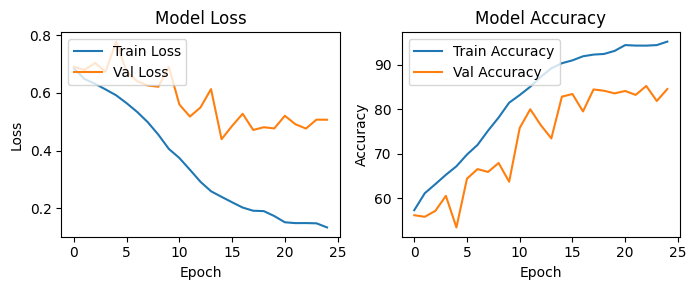

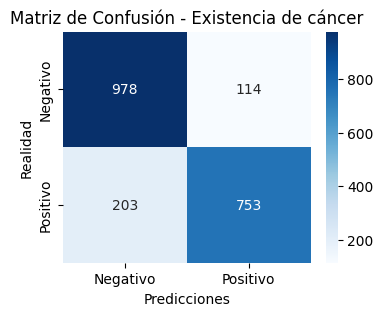

Precisión global: 84.52%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.83      0.90      0.86      1092
    Positivo       0.87      0.79      0.83       956

    accuracy                           0.85      2048
   macro avg       0.85      0.84      0.84      2048
weighted avg       0.85      0.85      0.84      2048

Precisión: 0.87
Sensibilidad (Recall): 0.79
F1-Score: 0.83
Accuracy: 0.85
Especificidad: 0.90


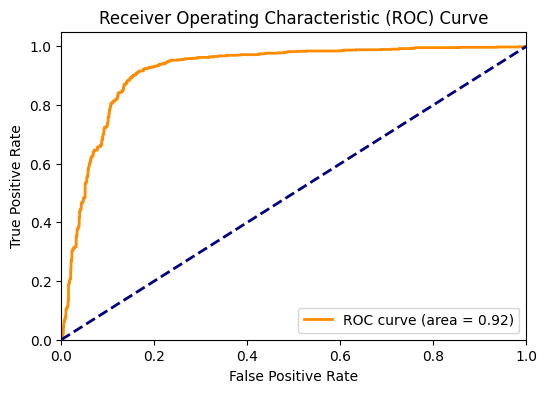

0.9183822627860283

In [ ]:
models_list.append("EnhancedCNN-LCN-GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
!pip install optuna

In [ ]:
# @title Tuning hiperparámetros
import optuna

# Redefinir la clase CNN para permitir ajuste de hiperparámetros
class CNNTune(nn.Module):
    def __init__(self, n_conv_layers, n_filters, fc_size, dropout_rate):
        super(CNNTune, self).__init__()

        # Definir secuencia de capas convolucionales
        layers = []
        in_channels = 1
        for i in range(n_conv_layers):
            out_channels = n_filters[i]  # Número de filtros
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            layers.append(nn.Dropout(dropout_rate))
            in_channels = out_channels

        self.features = nn.Sequential(*layers)

        initial_height = 224
        initial_width = 224

        # Número de capas convolucionales con `MaxPool2d`
        n_conv_layers = len(n_filters)

        # Cálculo del tamaño final después de todas las capas de `MaxPool2d`
        final_height = initial_height // (2 ** n_conv_layers)
        final_width = initial_width // (2 ** n_conv_layers)

        # Número de filtros de la última capa convolucional
        last_conv_filters = n_filters[-1]

        # Tamaño de entrada para la capa completamente conectada
        input_size = last_conv_filters * final_height * final_width

        self.classifier = nn.Sequential(
            nn.Linear(input_size, fc_size),
            nn.ReLU(),
            nn.Linear(fc_size, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Creación de función objetivo para Optuna
def objective(trial):
    # Hiperparámetros a ajustar
    n_conv_layers = trial.suggest_int(name="n_conv_layers", low=4, high=6, step=2)  # Número de capas conv.
    dropout_rate = trial.suggest_float(name="dropout_rate", low=0.2, high=0.5)  # Tasa de Dropout
    n_filters = [trial.suggest_int(f"filters_{i}", 32, 128) for i in range(n_conv_layers)]
    fc_size = trial.suggest_int("fc_size", 64, 256)  # Tamaño de la capa densa
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD"])

    # Creamos el modelo
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNNTune(n_conv_layers, n_filters, fc_size, dropout_rate)
    model.to(device)

    if optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Entrenar
    criterion = nn.CrossEntropyLoss()  # Cambiar según tu problema
    for epoch in tqdm(range(10), desc="Epochs", leave=False):  # Ajustar número de épocas
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

    # Evaluación
    correct = 0
    total = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = correct / total
    return accuracy

In [ ]:
## Datos de salida del estudio de Optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros:")
print(study.best_trial.params)

[I 2024-05-14 15:13:05,653] A new study created in memory with name: no-name-88d1250b-9cd9-4ca8-86f6-32b718f5082c
[I 2024-05-14 15:17:23,158] Trial 0 finished with value: 0.53173828125 and parameters: {'n_conv_layers': 6, 'dropout_rate': 0.42823807155814964, 'filters_0': 55, 'filters_1': 33, 'filters_2': 128, 'filters_3': 87, 'filters_4': 119, 'filters_5': 50, 'fc_size': 180, 'learning_rate': 0.004276581582176906, 'optimizer': 'SGD'}. Best is trial 0 with value: 0.53173828125.
[I 2024-05-14 15:23:49,743] Trial 1 finished with value: 0.5654296875 and parameters: {'n_conv_layers': 6, 'dropout_rate': 0.2699449434306387, 'filters_0': 72, 'filters_1': 91, 'filters_2': 73, 'filters_3': 95, 'filters_4': 62, 'filters_5': 32, 'fc_size': 108, 'learning_rate': 0.0021453930854965406, 'optimizer': 'SGD'}. Best is trial 1 with value: 0.5654296875.
[I 2024-05-14 15:29:18,768] Trial 2 finished with value: 0.5673828125 and parameters: {'n_conv_layers': 4, 'dropout_rate': 0.49890302928995545, 'filters_0

Mejores hiperparámetros:
{'n_conv_layers': 4, 'dropout_rate': 0.20137560023478107, 'filters_0': 94, 'filters_1': 87, 'filters_2': 74, 'filters_3': 112, 'fc_size': 254, 'learning_rate': 0.0002967911733912819, 'optimizer': 'Adam'}


In [ ]:
print(next(model.parameters()).device)

cuda:0


In [ ]:
class EnhancedCNN2(nn.Module):
    def __init__(self):
        super(EnhancedCNN2, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 14 * 14, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        return x

model = EnhancedCNN2()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Número total de parámetros entrenables:", total_params)

Número total de parámetros entrenables: 13276225


In [ ]:
model = EnhancedCNN2()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_EnhancedCNN2.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:25<00:00, 24.19it/s]


Train Loss: 0.707, Train Accuracy: 50.89%, Val Loss: 0.6914, Val Accuracy: 54.30%, Time: 27.27 seconds
Validation loss mejorada a 0.691352. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:25<00:00, 24.07it/s]


Train Loss: 0.693, Train Accuracy: 52.92%, Val Loss: 0.7026, Val Accuracy: 47.41%, Time: 27.38 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 3/30: 100%|██████████| 619/619 [00:25<00:00, 24.00it/s]


Train Loss: 0.683, Train Accuracy: 55.98%, Val Loss: 0.6821, Val Accuracy: 57.52%, Time: 27.44 seconds
Validation loss mejorada a 0.682076. Guardando modelo...


Epoch 4/30: 100%|██████████| 619/619 [00:26<00:00, 23.60it/s]


Train Loss: 0.673, Train Accuracy: 58.52%, Val Loss: 0.6790, Val Accuracy: 56.30%, Time: 27.90 seconds
Validation loss mejorada a 0.678962. Guardando modelo...


Epoch 5/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.666, Train Accuracy: 59.23%, Val Loss: 0.6776, Val Accuracy: 56.40%, Time: 27.84 seconds
Validation loss mejorada a 0.677584. Guardando modelo...


Epoch 6/30: 100%|██████████| 619/619 [00:26<00:00, 23.74it/s]


Train Loss: 0.660, Train Accuracy: 60.52%, Val Loss: 0.6600, Val Accuracy: 59.28%, Time: 27.74 seconds
Validation loss mejorada a 0.659968. Guardando modelo...


Epoch 7/30: 100%|██████████| 619/619 [00:26<00:00, 23.65it/s]


Train Loss: 0.641, Train Accuracy: 63.11%, Val Loss: 0.6668, Val Accuracy: 58.45%, Time: 27.84 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 8/30: 100%|██████████| 619/619 [00:26<00:00, 23.64it/s]


Train Loss: 0.629, Train Accuracy: 64.70%, Val Loss: 0.6407, Val Accuracy: 62.84%, Time: 27.86 seconds
Validation loss mejorada a 0.640687. Guardando modelo...


Epoch 9/30: 100%|██████████| 619/619 [00:26<00:00, 23.69it/s]


Train Loss: 0.615, Train Accuracy: 65.39%, Val Loss: 0.6415, Val Accuracy: 63.13%, Time: 27.81 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 10/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.591, Train Accuracy: 68.41%, Val Loss: 0.6397, Val Accuracy: 63.57%, Time: 27.83 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 11/30: 100%|██████████| 619/619 [00:26<00:00, 23.65it/s]


Train Loss: 0.577, Train Accuracy: 69.84%, Val Loss: 0.6232, Val Accuracy: 65.19%, Time: 27.83 seconds
Validation loss mejorada a 0.623159. Guardando modelo...


Epoch 12/30: 100%|██████████| 619/619 [00:26<00:00, 23.62it/s]


Train Loss: 0.553, Train Accuracy: 71.71%, Val Loss: 0.6002, Val Accuracy: 67.33%, Time: 27.86 seconds
Validation loss mejorada a 0.600210. Guardando modelo...


Epoch 13/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.527, Train Accuracy: 73.41%, Val Loss: 0.6395, Val Accuracy: 65.58%, Time: 27.83 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 14/30: 100%|██████████| 619/619 [00:26<00:00, 23.65it/s]


Train Loss: 0.497, Train Accuracy: 75.74%, Val Loss: 0.5883, Val Accuracy: 69.97%, Time: 27.82 seconds
Validation loss mejorada a 0.588267. Guardando modelo...


Epoch 15/30: 100%|██████████| 619/619 [00:26<00:00, 23.65it/s]


Train Loss: 0.474, Train Accuracy: 77.34%, Val Loss: 0.5548, Val Accuracy: 71.29%, Time: 27.83 seconds
Validation loss mejorada a 0.554802. Guardando modelo...


Epoch 16/30: 100%|██████████| 619/619 [00:26<00:00, 23.65it/s]


Train Loss: 0.432, Train Accuracy: 80.12%, Val Loss: 0.5506, Val Accuracy: 73.83%, Time: 27.82 seconds
Validation loss mejorada a 0.550607. Guardando modelo...


Epoch 17/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.413, Train Accuracy: 81.53%, Val Loss: 0.5392, Val Accuracy: 74.12%, Time: 27.82 seconds
Validation loss mejorada a 0.539185. Guardando modelo...


Epoch 18/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.379, Train Accuracy: 83.13%, Val Loss: 0.4771, Val Accuracy: 79.05%, Time: 27.81 seconds
Validation loss mejorada a 0.477130. Guardando modelo...


Epoch 19/30: 100%|██████████| 619/619 [00:26<00:00, 23.64it/s]


Train Loss: 0.363, Train Accuracy: 83.98%, Val Loss: 0.4970, Val Accuracy: 77.00%, Time: 27.84 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 20/30: 100%|██████████| 619/619 [00:26<00:00, 23.65it/s]


Train Loss: 0.341, Train Accuracy: 85.61%, Val Loss: 0.5055, Val Accuracy: 76.86%, Time: 27.83 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 21/30: 100%|██████████| 619/619 [00:26<00:00, 23.64it/s]


Train Loss: 0.323, Train Accuracy: 86.03%, Val Loss: 0.4480, Val Accuracy: 80.03%, Time: 27.85 seconds
Validation loss mejorada a 0.447977. Guardando modelo...


Epoch 22/30: 100%|██████████| 619/619 [00:26<00:00, 23.61it/s]


Train Loss: 0.296, Train Accuracy: 88.07%, Val Loss: 0.4334, Val Accuracy: 81.40%, Time: 27.87 seconds
Validation loss mejorada a 0.433405. Guardando modelo...


Epoch 23/30: 100%|██████████| 619/619 [00:26<00:00, 23.55it/s]


Train Loss: 0.280, Train Accuracy: 88.67%, Val Loss: 0.4595, Val Accuracy: 80.86%, Time: 27.95 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 24/30: 100%|██████████| 619/619 [00:26<00:00, 23.58it/s]


Train Loss: 0.260, Train Accuracy: 89.60%, Val Loss: 0.4380, Val Accuracy: 80.91%, Time: 27.95 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 25/30: 100%|██████████| 619/619 [00:26<00:00, 23.62it/s]


Train Loss: 0.245, Train Accuracy: 90.00%, Val Loss: 0.4791, Val Accuracy: 80.13%, Time: 27.86 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 26/30: 100%|██████████| 619/619 [00:26<00:00, 23.62it/s]


Train Loss: 0.228, Train Accuracy: 90.96%, Val Loss: 0.4763, Val Accuracy: 80.76%, Time: 27.86 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 27/30: 100%|██████████| 619/619 [00:26<00:00, 23.62it/s]


Train Loss: 0.215, Train Accuracy: 91.39%, Val Loss: 0.3993, Val Accuracy: 84.23%, Time: 27.87 seconds
Validation loss mejorada a 0.399283. Guardando modelo...


Epoch 28/30: 100%|██████████| 619/619 [00:26<00:00, 23.63it/s]


Train Loss: 0.207, Train Accuracy: 91.77%, Val Loss: 0.4015, Val Accuracy: 83.98%, Time: 27.86 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 29/30: 100%|██████████| 619/619 [00:26<00:00, 23.62it/s]


Train Loss: 0.204, Train Accuracy: 92.06%, Val Loss: 0.4125, Val Accuracy: 83.79%, Time: 27.88 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 30/30: 100%|██████████| 619/619 [00:26<00:00, 23.59it/s]


Train Loss: 0.193, Train Accuracy: 92.67%, Val Loss: 0.4948, Val Accuracy: 81.45%, Time: 27.88 seconds
EarlyStopping no mejoró en 3 épocas


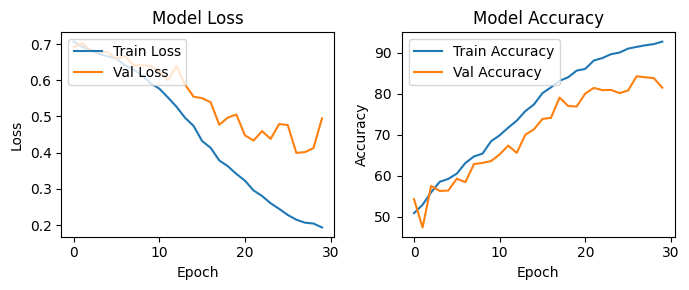

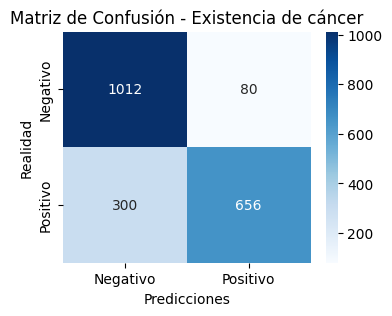

Precisión global: 81.45%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.77      0.93      0.84      1092
    Positivo       0.89      0.69      0.78       956

    accuracy                           0.81      2048
   macro avg       0.83      0.81      0.81      2048
weighted avg       0.83      0.81      0.81      2048

Precisión: 0.89
Sensibilidad (Recall): 0.69
F1-Score: 0.78
Accuracy: 0.81
Especificidad: 0.93


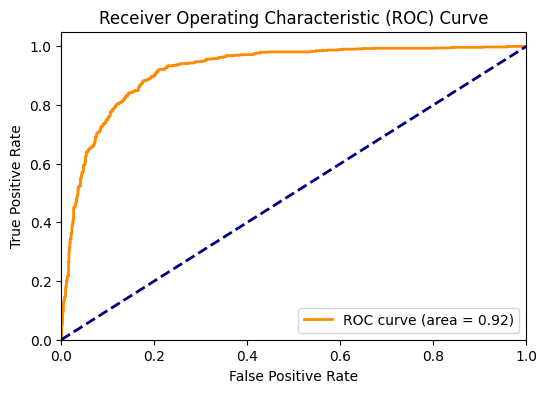

0.9206390715281929

In [ ]:
models_list.append("Combined_EnhancedCNN2");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
class EnhancedCNNMoreConv(nn.Module):
    def __init__(self):
        super(EnhancedCNNMoreConv, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = EnhancedCNNMoreConv()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Número total de parámetros entrenables:", total_params)

Número total de parámetros entrenables: 14482625


In [ ]:
model = EnhancedCNNMoreConv()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_EnhancedCNNMoreConv.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,50,device,eaStop)

Epoch 1/50: 100%|██████████| 619/619 [00:28<00:00, 21.95it/s]


Train Loss: 0.698, Train Accuracy: 53.07%, Val Loss: 0.7035, Val Accuracy: 53.86%, Time: 30.00 seconds
Validation loss mejorada a 0.703529. Guardando modelo...


Epoch 2/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.675, Train Accuracy: 57.73%, Val Loss: 0.7018, Val Accuracy: 55.22%, Time: 30.26 seconds
Validation loss mejorada a 0.701754. Guardando modelo...


Epoch 3/50: 100%|██████████| 619/619 [00:28<00:00, 21.81it/s]


Train Loss: 0.661, Train Accuracy: 60.42%, Val Loss: 0.6703, Val Accuracy: 58.35%, Time: 30.21 seconds
Validation loss mejorada a 0.670343. Guardando modelo...


Epoch 4/50: 100%|██████████| 619/619 [00:28<00:00, 21.70it/s]


Train Loss: 0.650, Train Accuracy: 60.98%, Val Loss: 0.6630, Val Accuracy: 59.13%, Time: 30.32 seconds
Validation loss mejorada a 0.662961. Guardando modelo...


Epoch 5/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.639, Train Accuracy: 62.69%, Val Loss: 0.6694, Val Accuracy: 58.35%, Time: 30.28 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 6/50: 100%|██████████| 619/619 [00:28<00:00, 21.77it/s]


Train Loss: 0.625, Train Accuracy: 64.47%, Val Loss: 0.6581, Val Accuracy: 61.13%, Time: 30.23 seconds
Validation loss mejorada a 0.658146. Guardando modelo...


Epoch 7/50: 100%|██████████| 619/619 [00:28<00:00, 21.75it/s]


Train Loss: 0.606, Train Accuracy: 66.22%, Val Loss: 0.6633, Val Accuracy: 59.42%, Time: 30.27 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 8/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.589, Train Accuracy: 67.66%, Val Loss: 0.6429, Val Accuracy: 64.60%, Time: 30.26 seconds
Validation loss mejorada a 0.642879. Guardando modelo...


Epoch 9/50: 100%|██████████| 619/619 [00:28<00:00, 21.73it/s]


Train Loss: 0.567, Train Accuracy: 70.06%, Val Loss: 0.6473, Val Accuracy: 62.16%, Time: 30.29 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 10/50: 100%|██████████| 619/619 [00:28<00:00, 21.69it/s]


Train Loss: 0.531, Train Accuracy: 72.57%, Val Loss: 0.7131, Val Accuracy: 63.48%, Time: 30.33 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 11/50: 100%|██████████| 619/619 [00:28<00:00, 21.68it/s]


Train Loss: 0.504, Train Accuracy: 75.19%, Val Loss: 0.6402, Val Accuracy: 65.72%, Time: 30.36 seconds
Validation loss mejorada a 0.640185. Guardando modelo...


Epoch 12/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.477, Train Accuracy: 76.99%, Val Loss: 0.5709, Val Accuracy: 71.58%, Time: 30.27 seconds
Validation loss mejorada a 0.570894. Guardando modelo...


Epoch 13/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.442, Train Accuracy: 79.52%, Val Loss: 0.5307, Val Accuracy: 75.05%, Time: 30.26 seconds
Validation loss mejorada a 0.530702. Guardando modelo...


Epoch 14/50: 100%|██████████| 619/619 [00:28<00:00, 21.71it/s]


Train Loss: 0.408, Train Accuracy: 81.10%, Val Loss: 0.5411, Val Accuracy: 75.29%, Time: 30.31 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 15/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.387, Train Accuracy: 82.63%, Val Loss: 0.6076, Val Accuracy: 72.56%, Time: 30.27 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 16/50: 100%|██████████| 619/619 [00:28<00:00, 21.72it/s]


Train Loss: 0.356, Train Accuracy: 84.32%, Val Loss: 0.5763, Val Accuracy: 73.78%, Time: 30.31 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 17/50: 100%|██████████| 619/619 [00:28<00:00, 21.69it/s]


Train Loss: 0.333, Train Accuracy: 85.66%, Val Loss: 0.5494, Val Accuracy: 75.20%, Time: 30.33 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 18/50: 100%|██████████| 619/619 [00:28<00:00, 21.69it/s]


Train Loss: 0.295, Train Accuracy: 87.36%, Val Loss: 0.5296, Val Accuracy: 78.17%, Time: 30.35 seconds
Validation loss mejorada a 0.529568. Guardando modelo...


Epoch 19/50: 100%|██████████| 619/619 [00:28<00:00, 21.71it/s]


Train Loss: 0.279, Train Accuracy: 87.91%, Val Loss: 0.5792, Val Accuracy: 76.03%, Time: 30.32 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 20/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.257, Train Accuracy: 89.14%, Val Loss: 0.6470, Val Accuracy: 73.24%, Time: 30.31 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 21/50: 100%|██████████| 619/619 [00:28<00:00, 21.72it/s]


Train Loss: 0.239, Train Accuracy: 90.08%, Val Loss: 0.5361, Val Accuracy: 77.98%, Time: 30.29 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 22/50: 100%|██████████| 619/619 [00:28<00:00, 21.75it/s]


Train Loss: 0.227, Train Accuracy: 91.14%, Val Loss: 0.5890, Val Accuracy: 75.73%, Time: 30.28 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 23/50: 100%|██████████| 619/619 [00:28<00:00, 21.75it/s]


Train Loss: 0.203, Train Accuracy: 91.94%, Val Loss: 0.5779, Val Accuracy: 76.61%, Time: 30.26 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 24/50: 100%|██████████| 619/619 [00:28<00:00, 21.74it/s]


Train Loss: 0.202, Train Accuracy: 92.05%, Val Loss: 0.5677, Val Accuracy: 79.49%, Time: 30.27 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 25/50: 100%|██████████| 619/619 [00:28<00:00, 21.76it/s]


Train Loss: 0.196, Train Accuracy: 92.48%, Val Loss: 0.5805, Val Accuracy: 79.05%, Time: 30.23 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 26/50: 100%|██████████| 619/619 [00:28<00:00, 21.77it/s]


Train Loss: 0.185, Train Accuracy: 92.73%, Val Loss: 0.4531, Val Accuracy: 83.54%, Time: 30.22 seconds
Validation loss mejorada a 0.453082. Guardando modelo...


Epoch 27/50: 100%|██████████| 619/619 [00:28<00:00, 21.76it/s]


Train Loss: 0.174, Train Accuracy: 93.20%, Val Loss: 0.4764, Val Accuracy: 82.96%, Time: 30.24 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 28/50: 100%|██████████| 619/619 [00:28<00:00, 21.77it/s]


Train Loss: 0.167, Train Accuracy: 93.52%, Val Loss: 0.7231, Val Accuracy: 75.39%, Time: 30.23 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 29/50: 100%|██████████| 619/619 [00:28<00:00, 21.76it/s]


Train Loss: 0.164, Train Accuracy: 93.81%, Val Loss: 0.5665, Val Accuracy: 79.69%, Time: 30.24 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 30/50: 100%|██████████| 619/619 [00:28<00:00, 21.76it/s]


Train Loss: 0.148, Train Accuracy: 94.46%, Val Loss: 0.5177, Val Accuracy: 82.08%, Time: 30.25 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 31/50: 100%|██████████| 619/619 [00:28<00:00, 21.75it/s]


Train Loss: 0.141, Train Accuracy: 94.75%, Val Loss: 0.5422, Val Accuracy: 80.91%, Time: 30.28 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 32/50: 100%|██████████| 619/619 [00:28<00:00, 21.77it/s]


Train Loss: 0.136, Train Accuracy: 95.01%, Val Loss: 0.6931, Val Accuracy: 77.00%, Time: 30.21 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 33/50: 100%|██████████| 619/619 [00:28<00:00, 21.78it/s]


Train Loss: 0.133, Train Accuracy: 94.99%, Val Loss: 0.5899, Val Accuracy: 81.54%, Time: 30.22 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 34/50: 100%|██████████| 619/619 [00:28<00:00, 21.76it/s]


Train Loss: 0.125, Train Accuracy: 95.34%, Val Loss: 0.5398, Val Accuracy: 82.81%, Time: 30.24 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 35/50: 100%|██████████| 619/619 [00:28<00:00, 21.78it/s]


Train Loss: 0.118, Train Accuracy: 95.54%, Val Loss: 0.6109, Val Accuracy: 79.00%, Time: 30.22 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 36/50: 100%|██████████| 619/619 [00:28<00:00, 21.79it/s]


Train Loss: 0.125, Train Accuracy: 95.38%, Val Loss: 0.5225, Val Accuracy: 83.40%, Time: 30.19 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


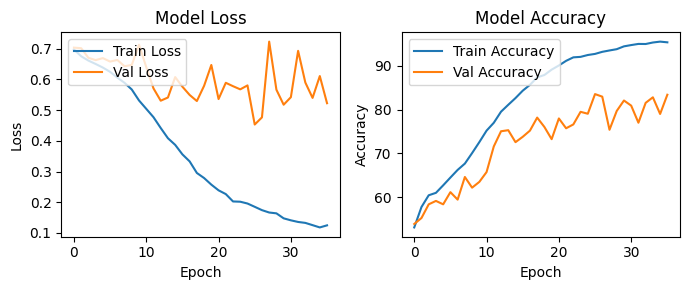

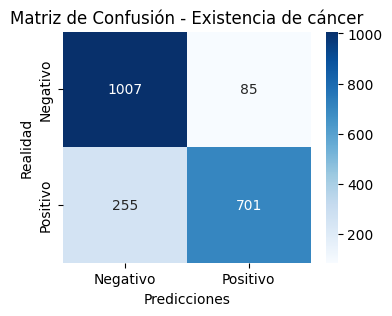

Precisión global: 83.40%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.80      0.92      0.86      1092
    Positivo       0.89      0.73      0.80       956

    accuracy                           0.83      2048
   macro avg       0.84      0.83      0.83      2048
weighted avg       0.84      0.83      0.83      2048

Precisión: 0.89
Sensibilidad (Recall): 0.73
F1-Score: 0.80
Accuracy: 0.83
Especificidad: 0.92


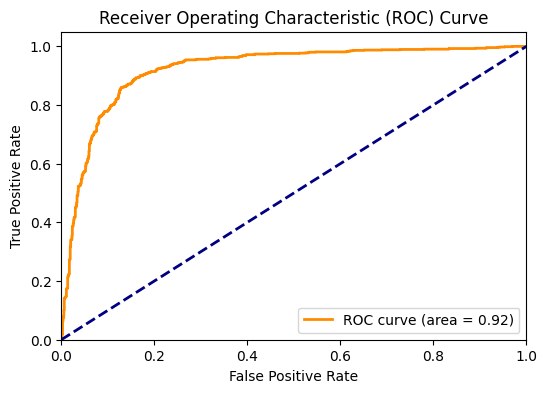

0.9215730225144451

In [ ]:
models_list.append("Combined_EnhancedCNN2_MoreConv");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import recall_score

# Prueba de ajuste de umbral para reducir falsos negativos

# Función para ajustar el umbral y evaluar el recall
def evaluate_threshold(model, dataloader, threshold):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().view(-1, 1)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            preds = (probabilities[:, 1] > threshold).int()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    recall = recall_score(all_labels, all_preds)
    return recall

thresholds = np.arange(0.1, 0.7, 0.1)
for threshold in thresholds:  # Umbral más bajo para reducir falsos negativos
  recall = evaluate_threshold(model, test_loader, threshold)
  print(f"Recall con umbral {threshold}: {recall}")

In [ ]:
model = EnhancedCNNMoreConv()
class_weights = torch.tensor([1.0, 2.0], device=device)
crit = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_EnhancedCNNMoreConv_ClassWeight.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,50,device,eaStop)

Epoch 1/50: 100%|██████████| 619/619 [00:28<00:00, 21.63it/s]


Train Loss: 0.644, Train Accuracy: 52.53%, Val Loss: 0.6517, Val Accuracy: 43.75%, Time: 30.39 seconds
Validation loss mejorada a 0.651658. Guardando modelo...


Epoch 2/50: 100%|██████████| 619/619 [00:28<00:00, 21.88it/s]


Train Loss: 0.627, Train Accuracy: 54.34%, Val Loss: 0.6417, Val Accuracy: 37.50%, Time: 30.04 seconds
Validation loss mejorada a 0.641744. Guardando modelo...


Epoch 3/50: 100%|██████████| 619/619 [00:28<00:00, 21.82it/s]


Train Loss: 0.609, Train Accuracy: 56.45%, Val Loss: 0.6326, Val Accuracy: 50.00%, Time: 30.51 seconds
Validation loss mejorada a 0.632580. Guardando modelo...


Epoch 4/50: 100%|██████████| 619/619 [00:28<00:00, 21.79it/s]


Train Loss: 0.601, Train Accuracy: 57.88%, Val Loss: 0.6321, Val Accuracy: 56.25%, Time: 30.17 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 5/50: 100%|██████████| 619/619 [00:28<00:00, 21.86it/s]


Train Loss: 0.587, Train Accuracy: 59.78%, Val Loss: 0.6282, Val Accuracy: 43.75%, Time: 30.08 seconds
Validation loss mejorada a 0.628182. Guardando modelo...


Epoch 6/50: 100%|██████████| 619/619 [00:28<00:00, 21.83it/s]


Train Loss: 0.575, Train Accuracy: 61.32%, Val Loss: 0.6218, Val Accuracy: 50.00%, Time: 30.11 seconds
Validation loss mejorada a 0.621828. Guardando modelo...


Epoch 7/50: 100%|██████████| 619/619 [00:28<00:00, 21.76it/s]


Train Loss: 0.557, Train Accuracy: 63.58%, Val Loss: 0.6229, Val Accuracy: 43.75%, Time: 30.20 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 8/50: 100%|██████████| 619/619 [00:28<00:00, 21.84it/s]


Train Loss: 0.541, Train Accuracy: 65.09%, Val Loss: 0.6253, Val Accuracy: 56.25%, Time: 30.13 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 9/50: 100%|██████████| 619/619 [00:28<00:00, 21.85it/s]


Train Loss: 0.511, Train Accuracy: 68.21%, Val Loss: 0.6275, Val Accuracy: 50.00%, Time: 30.14 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 10/50: 100%|██████████| 619/619 [00:28<00:00, 21.84it/s]


Train Loss: 0.481, Train Accuracy: 71.28%, Val Loss: 0.5982, Val Accuracy: 50.00%, Time: 30.11 seconds
Validation loss mejorada a 0.598184. Guardando modelo...


Epoch 11/50: 100%|██████████| 619/619 [00:29<00:00, 21.01it/s]


Train Loss: 0.452, Train Accuracy: 73.89%, Val Loss: 0.5539, Val Accuracy: 56.25%, Time: 31.22 seconds
Validation loss mejorada a 0.553860. Guardando modelo...


Epoch 12/50: 100%|██████████| 619/619 [00:28<00:00, 21.85it/s]


Train Loss: 0.422, Train Accuracy: 75.96%, Val Loss: 0.5399, Val Accuracy: 68.75%, Time: 30.09 seconds
Validation loss mejorada a 0.539942. Guardando modelo...


Epoch 13/50: 100%|██████████| 619/619 [00:28<00:00, 21.82it/s]


Train Loss: 0.382, Train Accuracy: 79.61%, Val Loss: 0.5614, Val Accuracy: 75.00%, Time: 30.13 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 14/50: 100%|██████████| 619/619 [00:28<00:00, 21.85it/s]


Train Loss: 0.362, Train Accuracy: 81.11%, Val Loss: 0.5056, Val Accuracy: 75.00%, Time: 30.13 seconds
Validation loss mejorada a 0.505617. Guardando modelo...


Epoch 15/50: 100%|██████████| 619/619 [00:28<00:00, 21.86it/s]


Train Loss: 0.332, Train Accuracy: 83.08%, Val Loss: 0.5176, Val Accuracy: 62.50%, Time: 30.07 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 16/50: 100%|██████████| 619/619 [00:28<00:00, 21.86it/s]


Train Loss: 0.305, Train Accuracy: 84.69%, Val Loss: 0.5075, Val Accuracy: 68.75%, Time: 30.08 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 17/50: 100%|██████████| 619/619 [00:28<00:00, 21.85it/s]


Train Loss: 0.292, Train Accuracy: 85.76%, Val Loss: 0.4422, Val Accuracy: 75.00%, Time: 30.09 seconds
Validation loss mejorada a 0.442225. Guardando modelo...


Epoch 18/50: 100%|██████████| 619/619 [00:28<00:00, 21.85it/s]


Train Loss: 0.252, Train Accuracy: 87.98%, Val Loss: 0.4743, Val Accuracy: 75.00%, Time: 30.09 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 19/50: 100%|██████████| 619/619 [00:28<00:00, 21.91it/s]


Train Loss: 0.243, Train Accuracy: 88.70%, Val Loss: 0.4734, Val Accuracy: 87.50%, Time: 30.04 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 20/50: 100%|██████████| 619/619 [00:28<00:00, 21.87it/s]


Train Loss: 0.232, Train Accuracy: 89.22%, Val Loss: 0.4912, Val Accuracy: 81.25%, Time: 30.10 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 21/50: 100%|██████████| 619/619 [00:28<00:00, 21.84it/s]


Train Loss: 0.214, Train Accuracy: 90.15%, Val Loss: 0.5423, Val Accuracy: 75.00%, Time: 30.10 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 22/50: 100%|██████████| 619/619 [00:28<00:00, 21.88it/s]


Train Loss: 0.202, Train Accuracy: 90.84%, Val Loss: 0.4514, Val Accuracy: 68.75%, Time: 30.05 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 23/50: 100%|██████████| 619/619 [00:28<00:00, 21.92it/s]


Train Loss: 0.188, Train Accuracy: 91.47%, Val Loss: 0.4983, Val Accuracy: 75.00%, Time: 29.99 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 24/50: 100%|██████████| 619/619 [00:28<00:00, 21.81it/s]


Train Loss: 0.180, Train Accuracy: 91.87%, Val Loss: 0.4269, Val Accuracy: 87.50%, Time: 30.15 seconds
Validation loss mejorada a 0.426873. Guardando modelo...


Epoch 25/50: 100%|██████████| 619/619 [00:28<00:00, 21.85it/s]


Train Loss: 0.166, Train Accuracy: 92.76%, Val Loss: 0.4825, Val Accuracy: 81.25%, Time: 30.11 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 26/50: 100%|██████████| 619/619 [00:28<00:00, 21.80it/s]


Train Loss: 0.157, Train Accuracy: 93.34%, Val Loss: 0.5159, Val Accuracy: 75.00%, Time: 30.21 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 27/50: 100%|██████████| 619/619 [00:28<00:00, 21.78it/s]


Train Loss: 0.146, Train Accuracy: 93.79%, Val Loss: 0.5934, Val Accuracy: 75.00%, Time: 30.18 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 28/50: 100%|██████████| 619/619 [00:28<00:00, 21.82it/s]


Train Loss: 0.147, Train Accuracy: 93.59%, Val Loss: 0.4128, Val Accuracy: 100.00%, Time: 30.14 seconds
Validation loss mejorada a 0.412786. Guardando modelo...


Epoch 29/50: 100%|██████████| 619/619 [00:28<00:00, 21.80it/s]


Train Loss: 0.131, Train Accuracy: 94.43%, Val Loss: 0.4474, Val Accuracy: 87.50%, Time: 30.17 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 30/50: 100%|██████████| 619/619 [00:28<00:00, 21.82it/s]


Train Loss: 0.140, Train Accuracy: 94.05%, Val Loss: 0.4500, Val Accuracy: 87.50%, Time: 30.13 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 31/50: 100%|██████████| 619/619 [00:28<00:00, 21.75it/s]


Train Loss: 0.131, Train Accuracy: 94.69%, Val Loss: 0.4710, Val Accuracy: 81.25%, Time: 30.29 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 32/50: 100%|██████████| 619/619 [00:28<00:00, 21.84it/s]


Train Loss: 0.118, Train Accuracy: 95.06%, Val Loss: 0.5127, Val Accuracy: 81.25%, Time: 30.11 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 33/50: 100%|██████████| 619/619 [00:28<00:00, 21.92it/s]


Train Loss: 0.119, Train Accuracy: 95.25%, Val Loss: 0.4528, Val Accuracy: 75.00%, Time: 29.99 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 34/50: 100%|██████████| 619/619 [00:28<00:00, 21.87it/s]


Train Loss: 0.113, Train Accuracy: 95.28%, Val Loss: 0.4183, Val Accuracy: 81.25%, Time: 30.07 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 35/50: 100%|██████████| 619/619 [00:28<00:00, 21.81it/s]


Train Loss: 0.099, Train Accuracy: 95.94%, Val Loss: 0.4965, Val Accuracy: 75.00%, Time: 30.15 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 36/50: 100%|██████████| 619/619 [00:28<00:00, 21.82it/s]


Train Loss: 0.110, Train Accuracy: 95.57%, Val Loss: 0.4629, Val Accuracy: 93.75%, Time: 30.16 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 37/50: 100%|██████████| 619/619 [00:28<00:00, 21.91it/s]


Train Loss: 0.094, Train Accuracy: 96.11%, Val Loss: 0.4417, Val Accuracy: 93.75%, Time: 30.04 seconds
EarlyStopping no mejoró en 9 épocas


Epoch 38/50: 100%|██████████| 619/619 [00:28<00:00, 21.90it/s]


Train Loss: 0.097, Train Accuracy: 96.10%, Val Loss: 0.4841, Val Accuracy: 93.75%, Time: 30.03 seconds
EarlyStopping no mejoró en 10 épocas
Early Stopping activado. Proceso detenido!


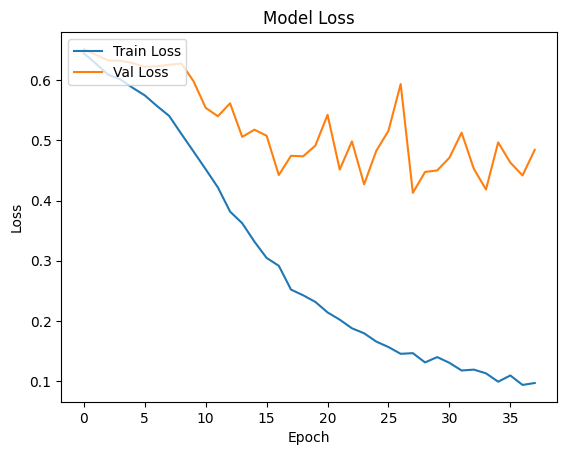

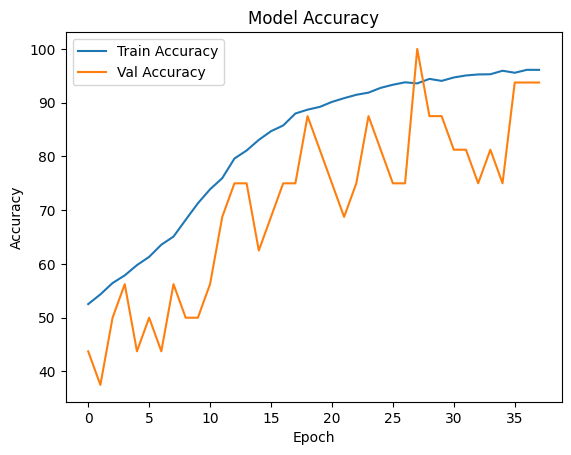

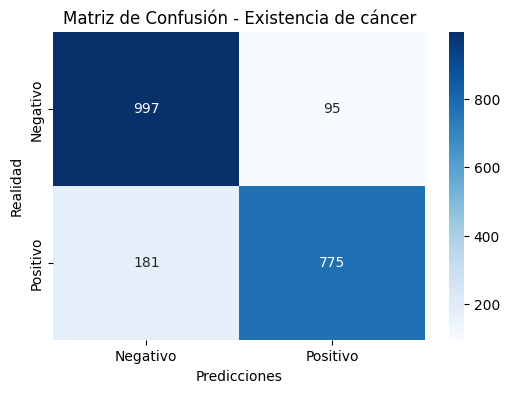

Precisión global: 86.52%
Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.85      0.91      0.88      1092
    Positivo       0.89      0.81      0.85       956

    accuracy                           0.87      2048
   macro avg       0.87      0.86      0.86      2048
weighted avg       0.87      0.87      0.86      2048

Precisión: 0.89
Sensibilidad (Recall): 0.81
F1-Score: 0.85
Accuracy: 0.87
Especificidad: 0.91


In [ ]:
models_list.append("Combined_EnhancedCNN2_MoreConv_ClassWeight");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)

In [ ]:
from skimage import exposure

def local_contrast_normalization(tensor, kernel_size=7):
    image = tensor.cpu().numpy()  # Convertir el tensor a numpy array
    images = []

    for i in range(image.shape[0]):
        img = image[i]

        local_mean = F.avg_pool2d(torch.tensor(img).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze().numpy()
        local_sqr_mean = F.avg_pool2d(torch.tensor(img**2).unsqueeze(0), kernel_size, stride=1, padding=kernel_size//2).squeeze().numpy()
        local_var = local_sqr_mean - local_mean**2
        local_std = np.sqrt(np.maximum(local_var, 1e-10))

        lcn_image = (img - local_mean) / (local_std + 1e-10)

        images.append(lcn_image)

    tensor = torch.tensor(np.stack(images)).to(tensor.device)
    return tensor

def global_contrast_normalization(image_tensor):
    mean = torch.mean(image_tensor)
    std_dev = torch.std(image_tensor)

    gcn_image_tensor = (image_tensor - mean) / torch.sqrt(std_dev ** 2 + 1e-6)

    return gcn_image_tensor

def LCN_GCN_preprocess(tensor):
    lcn_tensor = local_contrast_normalization(tensor)
    gcn_tensor = global_contrast_normalization(lcn_tensor)

    return gcn_tensor

X_train_LCN_GCN = LCN_GCN_preprocess(X_train)
X_test_LCN_GCN = LCN_GCN_preprocess(X_test)
# X_tensor_gcn = global_contrast_normalization(X_tensor)

# Dataset y DataLoader CON LOCAL CONTRAST NORMALIZATION Y GLOBAL CONTRAST NORMALIZATION
train_dataset = TensorDataset(X_train_LCN_GCN, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)

test_dataset = TensorDataset(X_test_LCN_GCN, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True)

In [ ]:
model = EnhancedCNN()
crit = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
fichModel = '/content/drive/MyDrive/output/models/Combined_CNN_GCN_LCN.pth'
eaStop = EarlyStopping(fichModel, patience=10, verbose=True, delta=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loss, train_accu, val_loss, val_accu = trainModel(model,train_loader,test_loader,crit,optimizer,30,device,eaStop)

Epoch 1/30: 100%|██████████| 619/619 [00:25<00:00, 23.98it/s]


Train Loss: 0.690, Train Accuracy: 56.42%, Val Loss: 0.7566, Val Accuracy: 53.81%, Time: 27.47 seconds
Validation loss mejorada a 0.756573. Guardando modelo...


Epoch 2/30: 100%|██████████| 619/619 [00:26<00:00, 23.59it/s]


Train Loss: 0.651, Train Accuracy: 61.85%, Val Loss: 0.7263, Val Accuracy: 52.54%, Time: 27.89 seconds
Validation loss mejorada a 0.726330. Guardando modelo...


Epoch 3/30: 100%|██████████| 619/619 [00:26<00:00, 23.72it/s]


Train Loss: 0.627, Train Accuracy: 63.97%, Val Loss: 0.6812, Val Accuracy: 58.98%, Time: 27.78 seconds
Validation loss mejorada a 0.681233. Guardando modelo...


Epoch 4/30: 100%|██████████| 619/619 [00:26<00:00, 23.77it/s]


Train Loss: 0.606, Train Accuracy: 65.68%, Val Loss: 0.7039, Val Accuracy: 57.91%, Time: 27.70 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 5/30: 100%|██████████| 619/619 [00:26<00:00, 23.77it/s]


Train Loss: 0.588, Train Accuracy: 67.42%, Val Loss: 0.7085, Val Accuracy: 59.47%, Time: 27.70 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 6/30: 100%|██████████| 619/619 [00:26<00:00, 23.75it/s]


Train Loss: 0.554, Train Accuracy: 70.10%, Val Loss: 0.6698, Val Accuracy: 62.70%, Time: 27.72 seconds
Validation loss mejorada a 0.669757. Guardando modelo...


Epoch 7/30: 100%|██████████| 619/619 [00:26<00:00, 23.74it/s]


Train Loss: 0.521, Train Accuracy: 73.19%, Val Loss: 0.7094, Val Accuracy: 63.04%, Time: 27.75 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 8/30: 100%|██████████| 619/619 [00:26<00:00, 23.72it/s]


Train Loss: 0.484, Train Accuracy: 75.65%, Val Loss: 0.7438, Val Accuracy: 60.01%, Time: 27.77 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 9/30: 100%|██████████| 619/619 [00:26<00:00, 23.74it/s]


Train Loss: 0.442, Train Accuracy: 78.74%, Val Loss: 0.6051, Val Accuracy: 72.95%, Time: 27.73 seconds
Validation loss mejorada a 0.605061. Guardando modelo...


Epoch 10/30: 100%|██████████| 619/619 [00:26<00:00, 23.70it/s]


Train Loss: 0.391, Train Accuracy: 81.89%, Val Loss: 0.6110, Val Accuracy: 73.10%, Time: 27.78 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 11/30: 100%|██████████| 619/619 [00:26<00:00, 23.70it/s]


Train Loss: 0.347, Train Accuracy: 84.77%, Val Loss: 0.5433, Val Accuracy: 76.22%, Time: 27.79 seconds
Validation loss mejorada a 0.543284. Guardando modelo...


Epoch 12/30: 100%|██████████| 619/619 [00:26<00:00, 23.75it/s]


Train Loss: 0.312, Train Accuracy: 86.47%, Val Loss: 0.5241, Val Accuracy: 77.93%, Time: 27.72 seconds
Validation loss mejorada a 0.524131. Guardando modelo...


Epoch 13/30: 100%|██████████| 619/619 [00:26<00:00, 23.74it/s]


Train Loss: 0.280, Train Accuracy: 88.33%, Val Loss: 0.4792, Val Accuracy: 82.37%, Time: 27.73 seconds
Validation loss mejorada a 0.479178. Guardando modelo...


Epoch 14/30: 100%|██████████| 619/619 [00:26<00:00, 23.73it/s]


Train Loss: 0.250, Train Accuracy: 89.79%, Val Loss: 0.5792, Val Accuracy: 75.88%, Time: 27.76 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 15/30: 100%|██████████| 619/619 [00:26<00:00, 23.74it/s]


Train Loss: 0.233, Train Accuracy: 90.66%, Val Loss: 0.4711, Val Accuracy: 81.30%, Time: 27.73 seconds
Validation loss mejorada a 0.471137. Guardando modelo...


Epoch 16/30: 100%|██████████| 619/619 [00:26<00:00, 23.72it/s]


Train Loss: 0.203, Train Accuracy: 91.97%, Val Loss: 0.4651, Val Accuracy: 83.40%, Time: 27.78 seconds
Validation loss mejorada a 0.465107. Guardando modelo...


Epoch 17/30: 100%|██████████| 619/619 [00:26<00:00, 23.71it/s]


Train Loss: 0.185, Train Accuracy: 92.67%, Val Loss: 0.4614, Val Accuracy: 83.54%, Time: 27.76 seconds
Validation loss mejorada a 0.461418. Guardando modelo...


Epoch 18/30: 100%|██████████| 619/619 [00:26<00:00, 23.70it/s]


Train Loss: 0.188, Train Accuracy: 92.50%, Val Loss: 0.4748, Val Accuracy: 81.54%, Time: 27.79 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 19/30: 100%|██████████| 619/619 [00:26<00:00, 23.64it/s]


Train Loss: 0.157, Train Accuracy: 93.71%, Val Loss: 0.4954, Val Accuracy: 82.08%, Time: 27.84 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 20/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.145, Train Accuracy: 94.68%, Val Loss: 0.5762, Val Accuracy: 79.44%, Time: 27.82 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 21/30: 100%|██████████| 619/619 [00:26<00:00, 23.68it/s]


Train Loss: 0.137, Train Accuracy: 94.76%, Val Loss: 0.4326, Val Accuracy: 86.33%, Time: 27.80 seconds
Validation loss mejorada a 0.432638. Guardando modelo...


Epoch 22/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.138, Train Accuracy: 94.66%, Val Loss: 0.4846, Val Accuracy: 84.47%, Time: 27.85 seconds
EarlyStopping no mejoró en 1 épocas


Epoch 23/30: 100%|██████████| 619/619 [00:26<00:00, 23.66it/s]


Train Loss: 0.129, Train Accuracy: 95.19%, Val Loss: 0.5494, Val Accuracy: 81.20%, Time: 27.83 seconds
EarlyStopping no mejoró en 2 épocas


Epoch 24/30: 100%|██████████| 619/619 [00:26<00:00, 23.64it/s]


Train Loss: 0.132, Train Accuracy: 94.86%, Val Loss: 0.4468, Val Accuracy: 85.94%, Time: 27.86 seconds
EarlyStopping no mejoró en 3 épocas


Epoch 25/30: 100%|██████████| 619/619 [00:26<00:00, 23.62it/s]


Train Loss: 0.120, Train Accuracy: 95.44%, Val Loss: 0.4832, Val Accuracy: 87.06%, Time: 27.86 seconds
EarlyStopping no mejoró en 4 épocas


Epoch 26/30: 100%|██████████| 619/619 [00:26<00:00, 23.69it/s]


Train Loss: 0.113, Train Accuracy: 95.65%, Val Loss: 0.5092, Val Accuracy: 82.28%, Time: 27.81 seconds
EarlyStopping no mejoró en 5 épocas


Epoch 27/30: 100%|██████████| 619/619 [00:26<00:00, 23.68it/s]


Train Loss: 0.112, Train Accuracy: 95.78%, Val Loss: 0.4421, Val Accuracy: 85.55%, Time: 27.81 seconds
EarlyStopping no mejoró en 6 épocas


Epoch 28/30: 100%|██████████| 619/619 [00:26<00:00, 23.71it/s]


Train Loss: 0.103, Train Accuracy: 96.09%, Val Loss: 0.5080, Val Accuracy: 83.69%, Time: 27.79 seconds
EarlyStopping no mejoró en 7 épocas


Epoch 29/30: 100%|██████████| 619/619 [00:26<00:00, 23.69it/s]


Train Loss: 0.101, Train Accuracy: 96.42%, Val Loss: 0.5284, Val Accuracy: 83.45%, Time: 27.80 seconds
EarlyStopping no mejoró en 8 épocas


Epoch 30/30: 100%|██████████| 619/619 [00:26<00:00, 23.71it/s]


Train Loss: 0.091, Train Accuracy: 96.68%, Val Loss: 0.5019, Val Accuracy: 84.91%, Time: 27.78 seconds
EarlyStopping no mejoró en 9 épocas


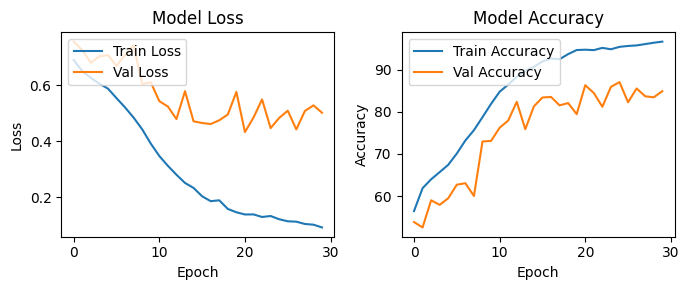

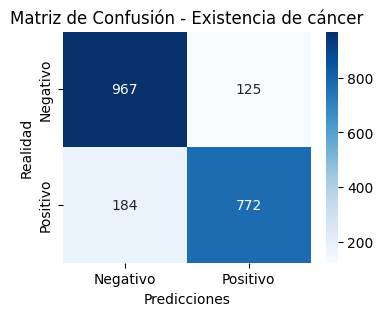

Precisión global: 84.91%

Informe y métricas de clasificación:
              precision    recall  f1-score   support

    Negativo       0.84      0.89      0.86      1092
    Positivo       0.86      0.81      0.83       956

    accuracy                           0.85      2048
   macro avg       0.85      0.85      0.85      2048
weighted avg       0.85      0.85      0.85      2048

Precisión: 0.86
Sensibilidad (Recall): 0.81
F1-Score: 0.83
Accuracy: 0.85
Especificidad: 0.89


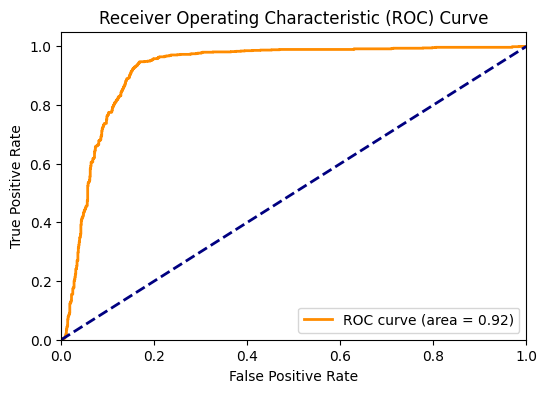

0.9205504659218049

In [ ]:
models_list.append("Combined_EnhancedCNN_LCN_GCN");
train_losses_list.append(train_loss)
train_accuracies_list.append(train_accu)
val_losses_list.append(val_loss)
val_accuracies_list.append(val_accu)

graphLossAccuracy(train_loss, val_loss, train_accu, val_accu)

metrics(model, test_loader)